In [634]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.stats.api as sms
import scipy.stats as stats
import statsmodels.api as sm

# PRIESKUMNÁ ANALÝZA

In [635]:
filePathOther = 'dataset/other_train.csv'
filePathPersonal = 'dataset/personal_train.csv'

dataOther = pd.read_csv(filePathOther, index_col=0)
dataPersonal = pd.read_csv(filePathPersonal, index_col=0)

data = pd.merge(dataOther, dataPersonal[['name', 'age', 'sex', 'date_of_birth']], on='name', how='left')

Najprv sme spojili záznamy z tabuliek personal a other aby sme dostali jednu tabuľku, v ktorej budú všetky potrebné záznamy spojené podľa mena

In [636]:
data.head()

,name,address,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,capital-gain,...,fnlwgt,class,std_glucose,income,mean_oxygen,hours-per-week,capital-loss,age,sex,date_of_birth
0,Brian Newhall,"52925 Barton Ville Suite 664\r\nEast Whitney, ...",8.289889,f,14.0,Not-in-family,-0.378956,119.445312,17.929757,0.0,...,192702.0,0.0,53.143057,<=50K,2.932274,50.0,0.0,69,Female,50-06-08
1,Patrick Behne,"037 Long Springs\r\nPort Maria, OH 58969",4.322444,t,6.0,Husband,4.146348,77.085938,43.980061,0.0,...,211116.0,1.0,43.391932,<=50K,10.596154,40.0,0.0,59,Male,1960-07-28 00 00 00
2,Steven Arnold,"471 Kevin Spurs Suite 564\r\nReneeland, NC 84482",4.702130,f,5.0,Own-child,-0.170853,126.046875,36.950157,0.0,...,173736.0,0.0,50.909365,<=50K,7.939799,40.0,0.0,3500,Male,1984-08-04
3,Mark Turner,"459 Parsons Centers\r\nWest Laura, UT 03831",15.348017,f,13.0,Husband,0.219464,109.289062,13.871366,0.0,...,303212.0,1.0,50.772802,>50K,0.950669,40.0,0.0,56,Male,1963-01-24
4,Mike Sams,"3148 Danielle Walk Apt. 320\r\nSaraborough, CA...",1.972958,f,12.0,Husband,18.011655,53.789062,67.752058,7688.0,...,191814.0,1.0,30.062085,>50K,30.670569,50.0,0.0,41,Male,1978-01-18


In [637]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3983 non-null   object 
 1   address           3983 non-null   object 
 2   kurtosis_oxygen   3962 non-null   float64
 3   pregnant          3968 non-null   object 
 4   education-num     3972 non-null   float64
 5   relationship      3970 non-null   object 
 6   skewness_glucose  3971 non-null   float64
 7   mean_glucose      3567 non-null   float64
 8   std_oxygen        3965 non-null   float64
 9   capital-gain      3975 non-null   float64
 10  skewness_oxygen   3968 non-null   float64
 11  kurtosis_glucose  3969 non-null   float64
 12  personal_info     3970 non-null   object 
 13  education         3969 non-null   object 
 14  fnlwgt            3964 non-null   float64
 15  class             3970 non-null   float64
 16  std_glucose       3974 non-null   float64


# Základné opravenie formátu dát

Stĺpec personal_info obsahoval v sebe 4 nenaformátované atribúty. Pre tieto atribúty sme vytvorili samostatné stĺpce a opravili sme ich tak, aby sa dali do týchto stĺpcov zapísať.

V stĺpci pregnant sme opravili nejednoznačné hodnoty (F, false, T, True sme opravili na f resp. t)

In [638]:
def insertColumns(data):
    data.insert(22, "employment", object)
    data.insert(23, "country", object)
    data.insert(24, "marriage", object)
    data.insert(25, "sector", object)
    data.insert(26, "race", object)
    
    return data

#data = insertColumns(data)

In [639]:
data.pregnant.unique()

array(['f', 't', 'F', 'FALSE', 'TRUE', nan, 'T'], dtype=object)

In [640]:
data.income.unique()

array([' <=50K', ' >50K', nan], dtype=object)

In [641]:
def fixPersonalInfo():
    for index, row in data.iterrows():
        personal_info = row['personal_info']

        personal_info = str(personal_info)
        personal_info = personal_info.replace("|", ",")
        personal_info = personal_info.replace("\r", "")
        personal_info = personal_info.replace("\n", ",")
        personal_info = personal_info.replace("''", "")
        personal_info = personal_info.replace(" --", ",")
        personal_info = personal_info.replace(" ", "")

        personal_info = personal_info.split(",")

        if(str(personal_info[0]) != "nan"):
            data.loc[index, "employment"] = str(personal_info[0])
            data.loc[index, "country"] = str(personal_info[1])
            data.loc[index, "marriage"] = str(personal_info[2])
            data.loc[index, "sector"] = str(personal_info[3])
            data.loc[index, "race"] = str(personal_info[4])
            
fixPersonalInfo()

Odstránili sme atribúty, ktoré nemajú pri analýze dát na pre nás zatiaľ žiadnu použiteľnú výpovednú hodnotu, ak budú neskôr potrebné môžeme ich opäť pridať a naopak ak identifikujeme nejaké ďalšie, ktoré zistíme, že nepotrebujeme, môžeme ich neskôr vyhodiť.

In [642]:
def dropColumnsFirst(data):
    data = data.drop('personal_info', axis = 1)
    data = data.drop('address', axis = 1)
    data = data.drop('relationship', axis = 1)
    data = data.drop('hours-per-week', axis = 1)
    data = data.drop('marriage', axis = 1)
    data = data.drop('employment', axis = 1)
    data = data.drop('sector', axis = 1)
    data = data.drop('income', axis = 1)
    data = data.drop('capital-loss', axis = 1)
    data = data.drop('education', axis = 1)
    data = data.drop('fnlwgt', axis = 1)
    data = data.drop('capital-gain', axis = 1)
    
    return data

data = dropColumnsFirst(data)

In [643]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3983 non-null   object 
 1   kurtosis_oxygen   3962 non-null   float64
 2   pregnant          3968 non-null   object 
 3   education-num     3972 non-null   float64
 4   skewness_glucose  3971 non-null   float64
 5   mean_glucose      3567 non-null   float64
 6   std_oxygen        3965 non-null   float64
 7   skewness_oxygen   3968 non-null   float64
 8   kurtosis_glucose  3969 non-null   float64
 9   class             3970 non-null   float64
 10  std_glucose       3974 non-null   float64
 11  mean_oxygen       3969 non-null   float64
 12  age               3983 non-null   int64  
 13  sex               3983 non-null   object 
 14  date_of_birth     3983 non-null   object 
 15  country           3970 non-null   object 
 16  race              3970 non-null   object 


In [644]:
def fixPregnant(data):
    data["pregnant"] = data["pregnant"].str.replace('FALSE', 'f')
    data["pregnant"] = data["pregnant"].str.replace('F', 'f')
    data["pregnant"] = data["pregnant"].str.replace('TRUE', 't')
    data["pregnant"] = data["pregnant"].str.replace('T', 't')
    
    return data

data = fixPregnant(data)

# Základný opis dát ich charakteristík

Počet stĺpcov a riadkov

In [645]:
data.shape

(3983, 17)

Náš dataset má 3983 riadkov a 17 stĺpcov.

In [646]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3983 non-null   object 
 1   kurtosis_oxygen   3962 non-null   float64
 2   pregnant          3968 non-null   object 
 3   education-num     3972 non-null   float64
 4   skewness_glucose  3971 non-null   float64
 5   mean_glucose      3567 non-null   float64
 6   std_oxygen        3965 non-null   float64
 7   skewness_oxygen   3968 non-null   float64
 8   kurtosis_glucose  3969 non-null   float64
 9   class             3970 non-null   float64
 10  std_glucose       3974 non-null   float64
 11  mean_oxygen       3969 non-null   float64
 12  age               3983 non-null   int64  
 13  sex               3983 non-null   object 
 14  date_of_birth     3983 non-null   object 
 15  country           3970 non-null   object 
 16  race              3970 non-null   object 


Takze mame k dispozcii 17 atribútov:

* Name: Diskretne hodnoty -> kategoricky atribut 
* kurtosis_oxygen: Realne numericke hodnoty -> spojity atribut
* pregnant: Diskretne hodnoty -> kategoricky atribut
* education-num: Diskretne hodnoty -> kategoricky atribut
* mean_glucose: Realne numericke hodnoty -> spojity atribut
* std_glucose: Realne numericke hodnoty -> spojity atribut
* std_oxygen: Realne numericke hodnoty -> spojity atribut
* skewness_glucose: Realne numericke hodnoty -> spojity atribut
* kurtosis_glucose: Realne numericke hodnoty -> spojity atribut
* class: Diskretne hodnoty -> kategoricky atribut
* std_glucose: Realne numericke hodnoty -> spojity atribut
* mean_oxygen: Realne numericke hodnoty -> spojity atribut
* age: Realne numericke hodnoty -> spojity atribut
* sex: Diskretne hodnoty -> kategoricky atribut
* date_of_birth: Diskretne hodnoty -> kategoricky atribut (tento pri analýze zatiaľ netreba, pri úprave dát ho však treba bude)
* country: Diskretne hodnoty -> kategoricky atribut
* race: Diskretne hodnoty -> kategoricky atribut

# Analýza po jednom
## Analýza spojitých atribútov

In [647]:
data[['std_glucose', 'mean_glucose', 'skewness_glucose', 'kurtosis_glucose']].describe()

,std_glucose,mean_glucose,skewness_glucose,kurtosis_glucose
count,3974.000000,3567.000000,3971.000000,3969.000000
mean,45.196785,101.327023,4.192579,0.946330
std,7.613055,33.521820,9.648298,1.605552
min,25.695250,6.187500,-1.755332,-1.641515
25%,40.199113,87.660156,-0.120195,0.071229
50%,45.895487,110.640625,0.372981,0.310186
75%,50.376893,124.277344,2.067417,0.770947
max,91.206475,189.734375,68.101622,8.069522


In [648]:
data['std_glucose'].dropna(inplace=True)
data['mean_glucose'].dropna(inplace=True)
data['skewness_glucose'].dropna(inplace=True)
data['kurtosis_glucose'].dropna(inplace=True)

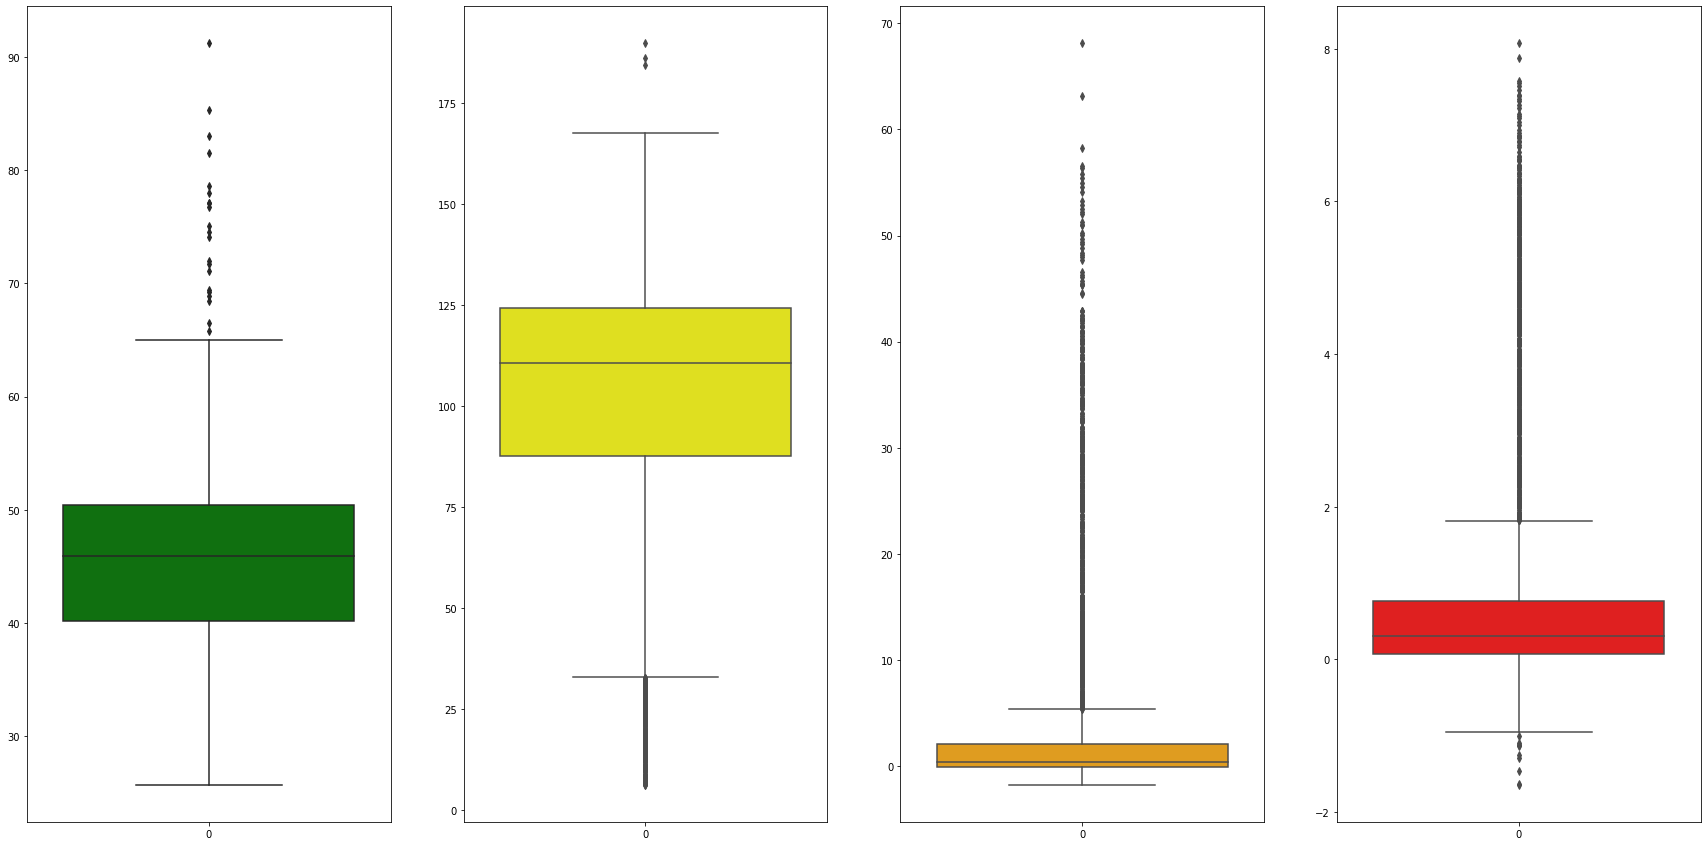

In [649]:
f, axes = plt.subplots(1, 4)
sns.boxplot(data = data['std_glucose'], orient='v', ax=axes[0], color = 'green')
sns.boxplot(data = data['mean_glucose'], orient='v', ax=axes[1], color = 'yellow')
sns.boxplot(data = data['skewness_glucose'], orient='v', ax=axes[2], color = 'orange')
sns.boxplot(data = data['kurtosis_glucose'], orient='v', ax=axes[3], color = 'red')

f.set_figwidth(30)
f.set_figheight(15)

V tomto grafe vidíme, že skewness a kurtosis glukózy obsahuje veľa outlierov a interkvartilové rozmedzie je príliš malé, čo značí abnormalitu v dátach.

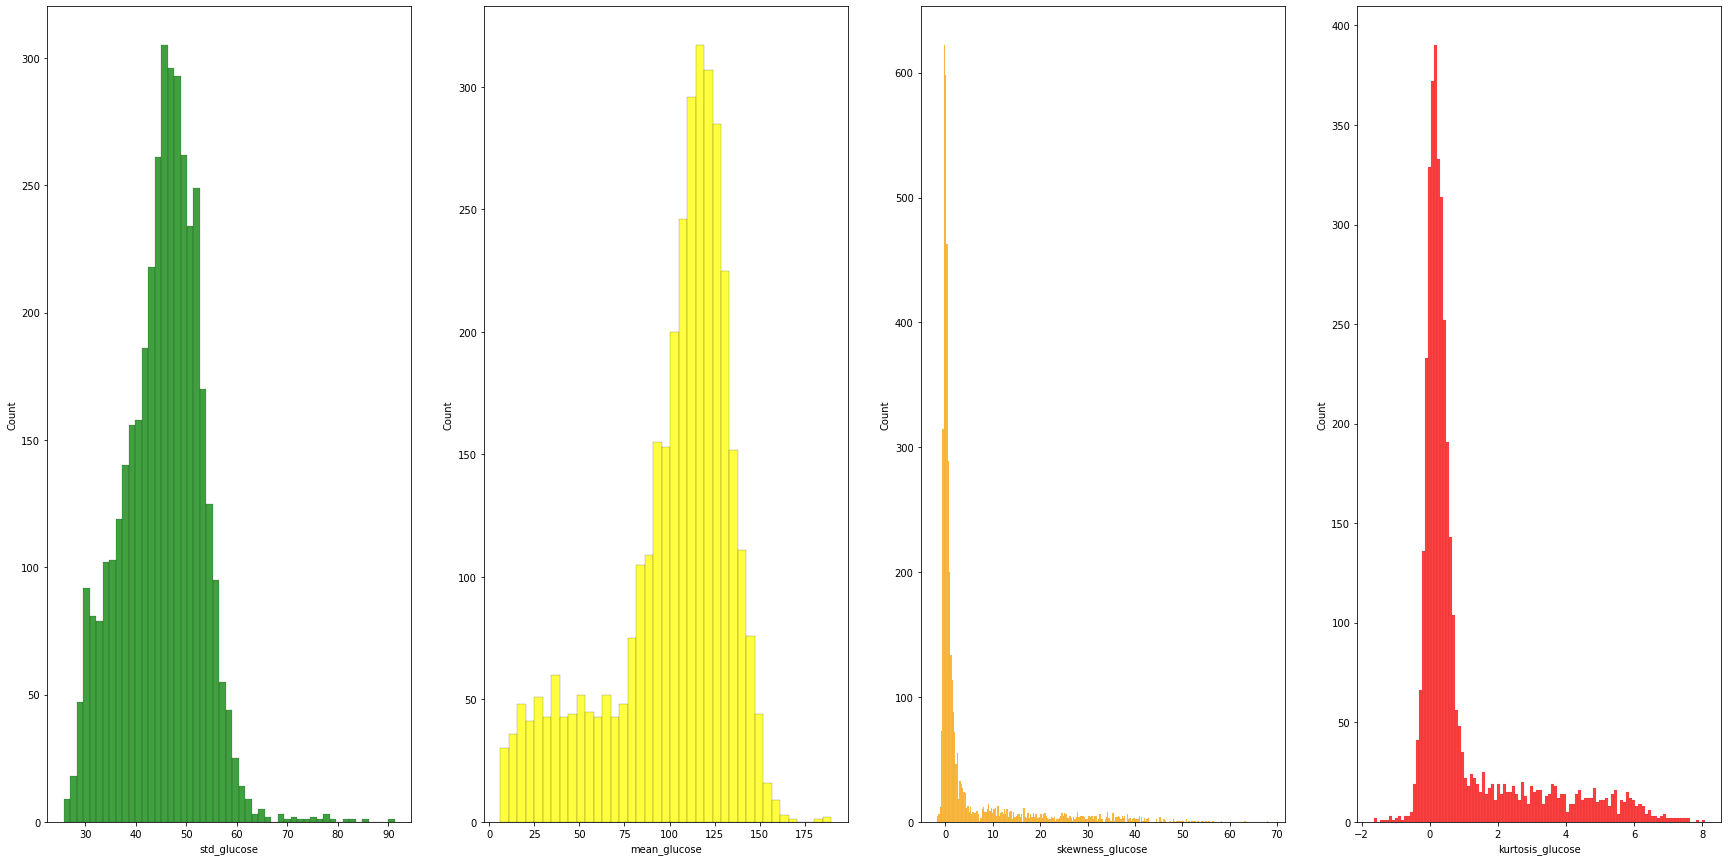

In [650]:
f, axes = plt.subplots(1, 4)
sns.histplot(data['std_glucose'], ax=axes[0], color = 'green')
sns.histplot(data['mean_glucose'], ax=axes[1], color = 'yellow')
sns.histplot(data['skewness_glucose'], ax=axes[2], color = 'orange')
sns.histplot(data['kurtosis_glucose'], ax=axes[3], color = 'red')
f.set_figwidth(30)
f.set_figheight(15)

Z tretieho grafu skewness_glucose môžeme vidieť, že graf nie je rovnomerne distribuovaný, ale jeho hodnoty sa v drvivej väčšine objavujú okolo hodnoty 0 až 5, čo nám potvrdzuje aj predchádzajúca tabuľka, ktorá vypočítala priemernú hodnotu 4.192579 čo nám symbolizuje pomerne veľkú asymetriu vzhľadom na nulu. Keďže sa jedná o hodnotu skewness, teda koeficientu asymetrie a hodnoty sa pohybujú prevažne v kladných číslach, vieme, že dáta sú naklonené do ľava.

Zo štvrtého grafu, ktorý zobrazuje hodnoty kurtosis_glucose, teda koeficientu špicatosti, môžeme vidieť, že veľká časť dát sa pohybuje okolo hodnoty 0. Priemerná hodnota je však 0.947, čo v porovnaní s koeficientom normálneho rozdelenia, ktoré je 3, je menej a znamená to, že na okrajoch je sústredených menej dát.

In [651]:
data[['std_oxygen', 'mean_oxygen', 'skewness_oxygen', 'kurtosis_oxygen']].describe()

,std_oxygen,mean_oxygen,skewness_oxygen,kurtosis_oxygen
count,3965.000000,3969.000000,3968.000000,3962.000000
mean,31.117496,18.374766,91.430852,7.428899
std,22.262023,34.663280,108.622734,4.817449
min,7.370432,0.213211,-1.976976,-2.597872
25%,15.024700,2.061873,12.928386,3.667526
50%,20.547873,3.237458,68.505049,7.787156
75%,43.124802,12.603679,127.057043,10.278883
max,110.642211,217.371238,1191.000837,34.539844


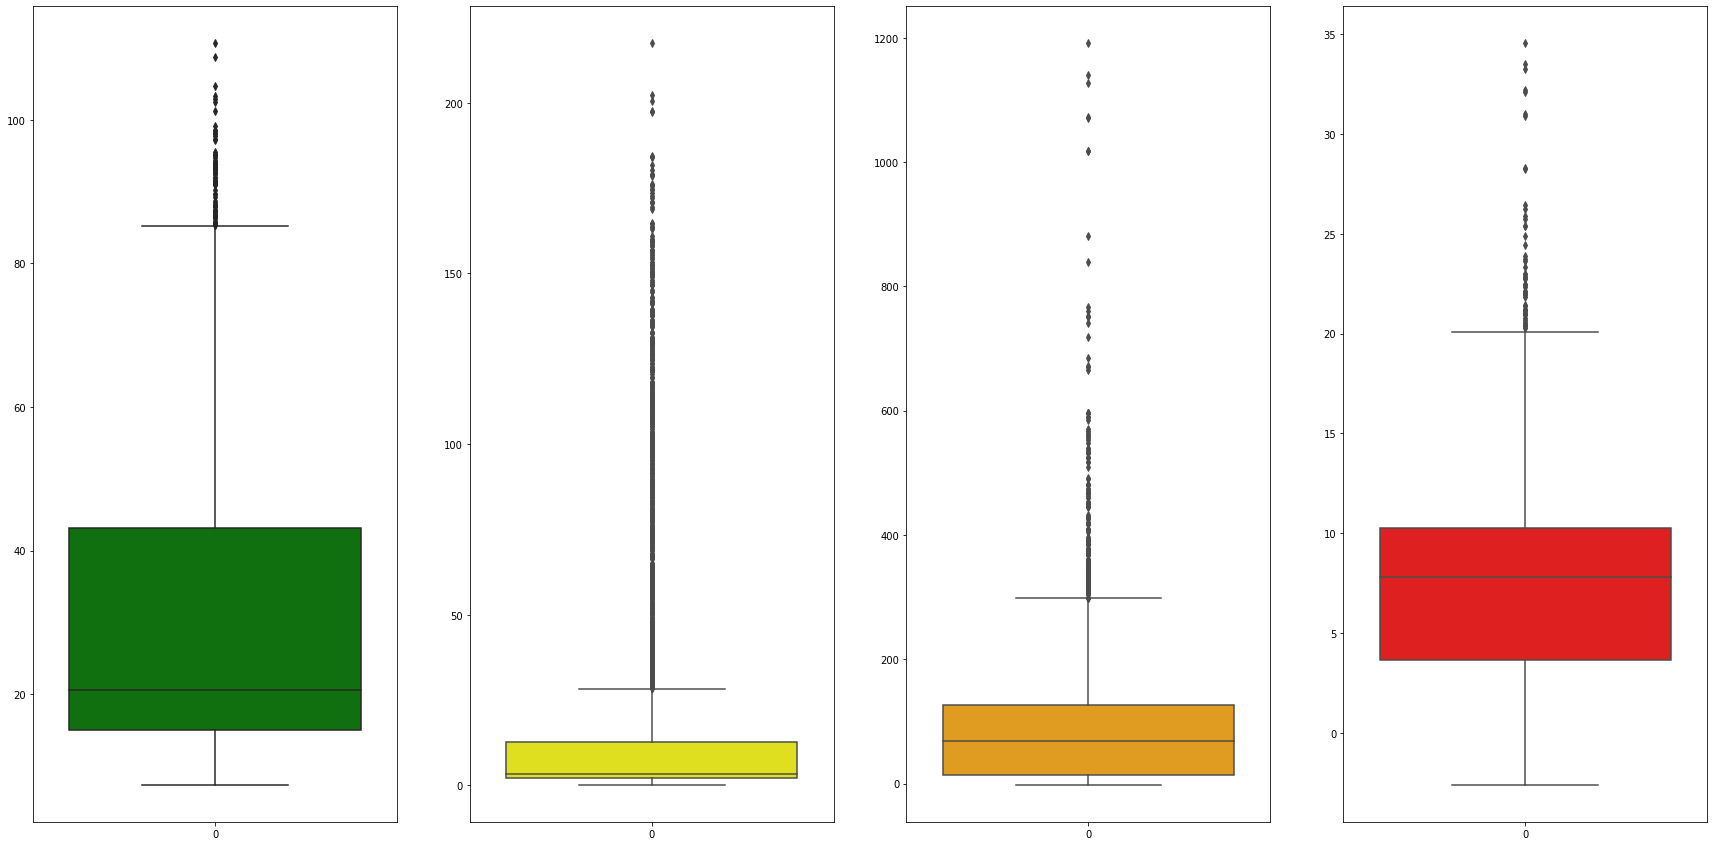

In [652]:
f, axes = plt.subplots(1, 4)
sns.boxplot(data = data['std_oxygen'], orient='v', ax=axes[0], color = 'green')
sns.boxplot(data = data['mean_oxygen'], orient='v', ax=axes[1], color = 'yellow')
sns.boxplot(data = data['skewness_oxygen'], orient='v', ax=axes[2], color = 'orange')
sns.boxplot(data = data['kurtosis_oxygen'], orient='v', ax=axes[3], color = 'red')

f.set_figwidth(30)
f.set_figheight(15)

V tomto grafe opäť vidíme, že záznamy pre priemer a skewness kyslíka obsahujú veľa outlierov a interkvartilové rozmedzie znova je príliš malé, čo značí abnormalitu v dátach.

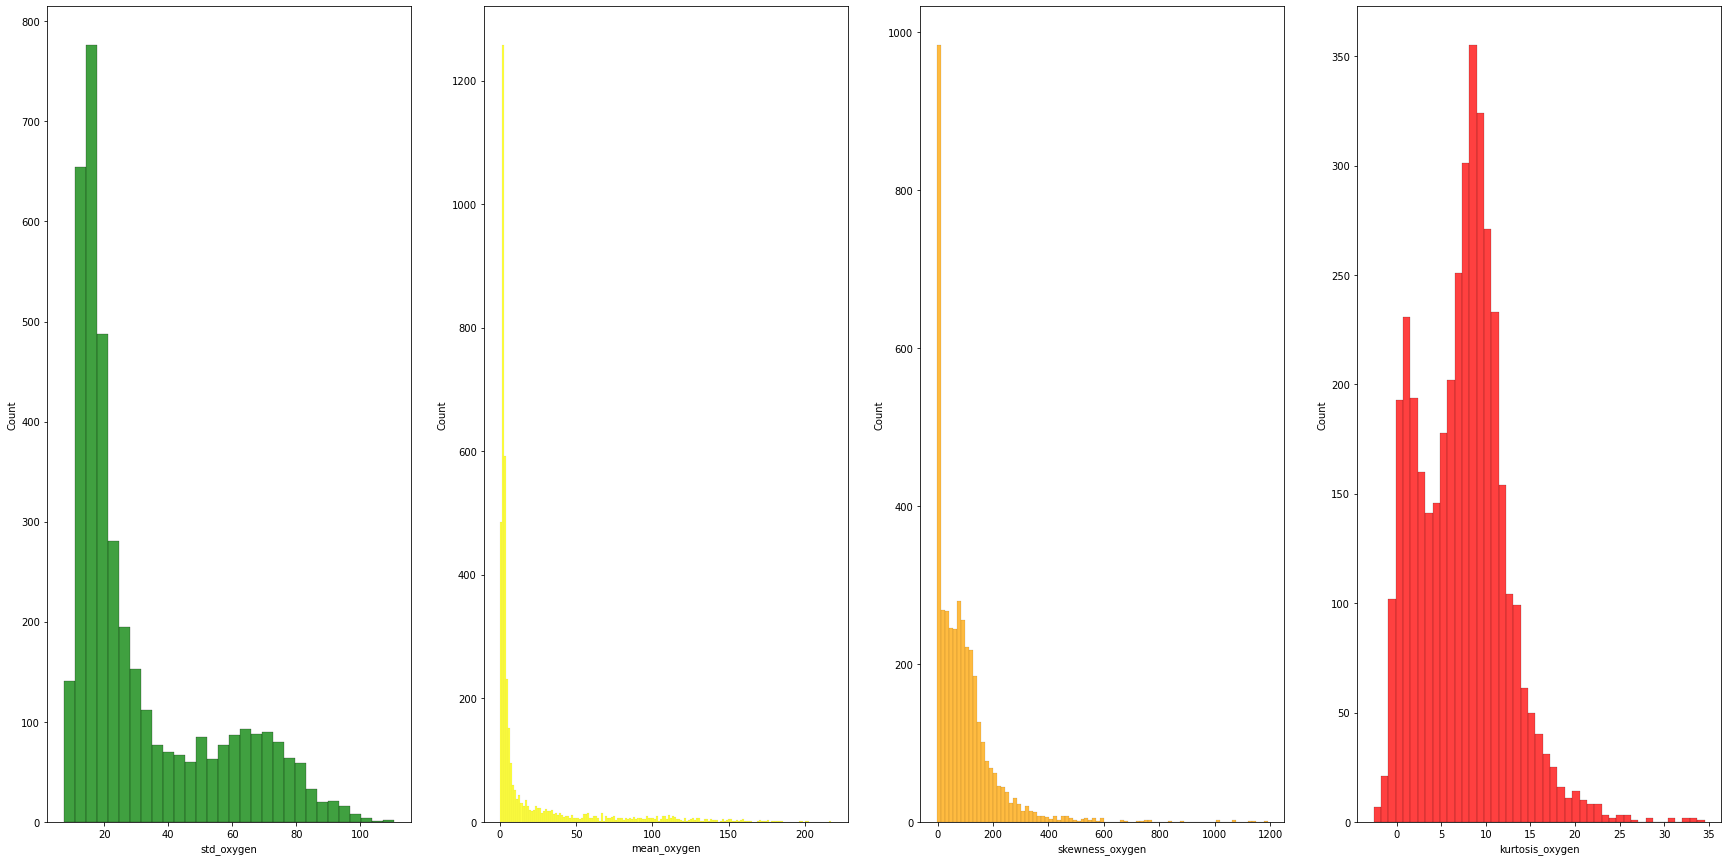

In [653]:
f, axes = plt.subplots(1, 4)
sns.histplot(data['std_oxygen'], ax=axes[0], color = 'green')
sns.histplot(data['mean_oxygen'], ax=axes[1], color = 'yellow')
sns.histplot(data['skewness_oxygen'], ax=axes[2], color = 'orange')
sns.histplot(data['kurtosis_oxygen'], ax=axes[3], color = 'red')
f.set_figwidth(30)
f.set_figheight(15)

Z tretieho grafu skewness_oxygen môžeme vidieť, že graf taktiež nie je rovnomerne distribuovaný, ale jeho hodnoty sa v drvivej väčšine objavujú okolo hodnoty 0 až 400, čo nám potvrdzuje aj predchádzajúca tabuľka, ktorá vypočítala priemernú hodnotu až 91.43 čo značí veľmi veľký sklon dát na ľavú stranu.

Zo štvrtého grafu, ktorý zobrazuje hodnoty kurtosis_oxygen, môžeme vidieť, že veľká časť dát sa pohybuje v rozmedzí 0 a 15 a z tabuľky vieme, že približná hodnota koeficientu špicatosti je 7.43. Keď túto hodnotu porovnáme s koeficientom normálneho rozdelenia, ktoré je 3, je to viac a znamená to, že na rozdiel od špicatosti glukózy, tento graf bude oveľa viac roztiahnutý do strán.

## Analýza kategorických atribútov

### Class - cukrovka

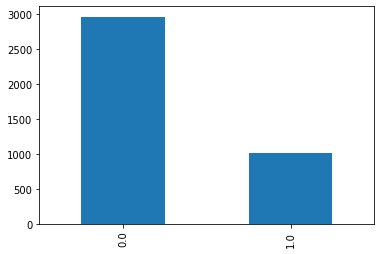

In [654]:
data['class'].value_counts().plot(kind='bar')

Z grafu môžeme vidieť, že máme takmer trojnásobne viac dát pre ľudí bez cukrovky, ako pre ľudí s cukrovkou.

### Vzdelanie

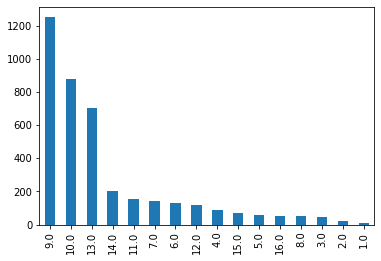

In [655]:
data['education-num'].value_counts().plot(kind='bar')

Z grafu je vidno, že vo väčšine kategórii máme veľmi málo dát, tieto informácie nám môžu byť užitočné neskôr v párovej analýze, ak nám niekde vyjdu podozrivo odlišné percentá, môžeme sa takto pozrieť, či vzorka z ktorej sú vyvodené je reprezentatívna.

### Pohlavie

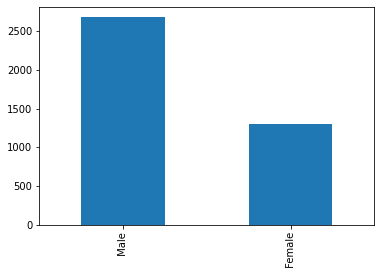

In [656]:
data['sex'].value_counts().plot(kind='bar')

Taktiež môžeme vidieť, že máme takmer dva krát toľko dát pre mužov ako pre ženy.

# Párová analýza dát
V tejto fáze sa pozrieme na vzťahy/koreláciu medzi významnými atribútmi. Na začiatok si zobrazíme všetky možnosti párovania spojitých atribútov a zanalyzujeme závislosť resp. nezávislosť daných atribútov - nájdeme zhluky dát, ktoré sa v nich vyskytujú. 

Pri porovnávaní spojitých a kategorických atribútov sa pozrieme na množinu hodnôt do ktorých zvyčajne kategorické atribúty spadajú pomocou boxplotov.

V neposlednom rade na preskúmanie vzťahov medzi dvoma kategorickými atrinútmi, ktoré si myslíme, že by spolu mohli potenciálne súvisieť, použijeme kontingenčné tabuľky.

## Spojité - spojité atribúty

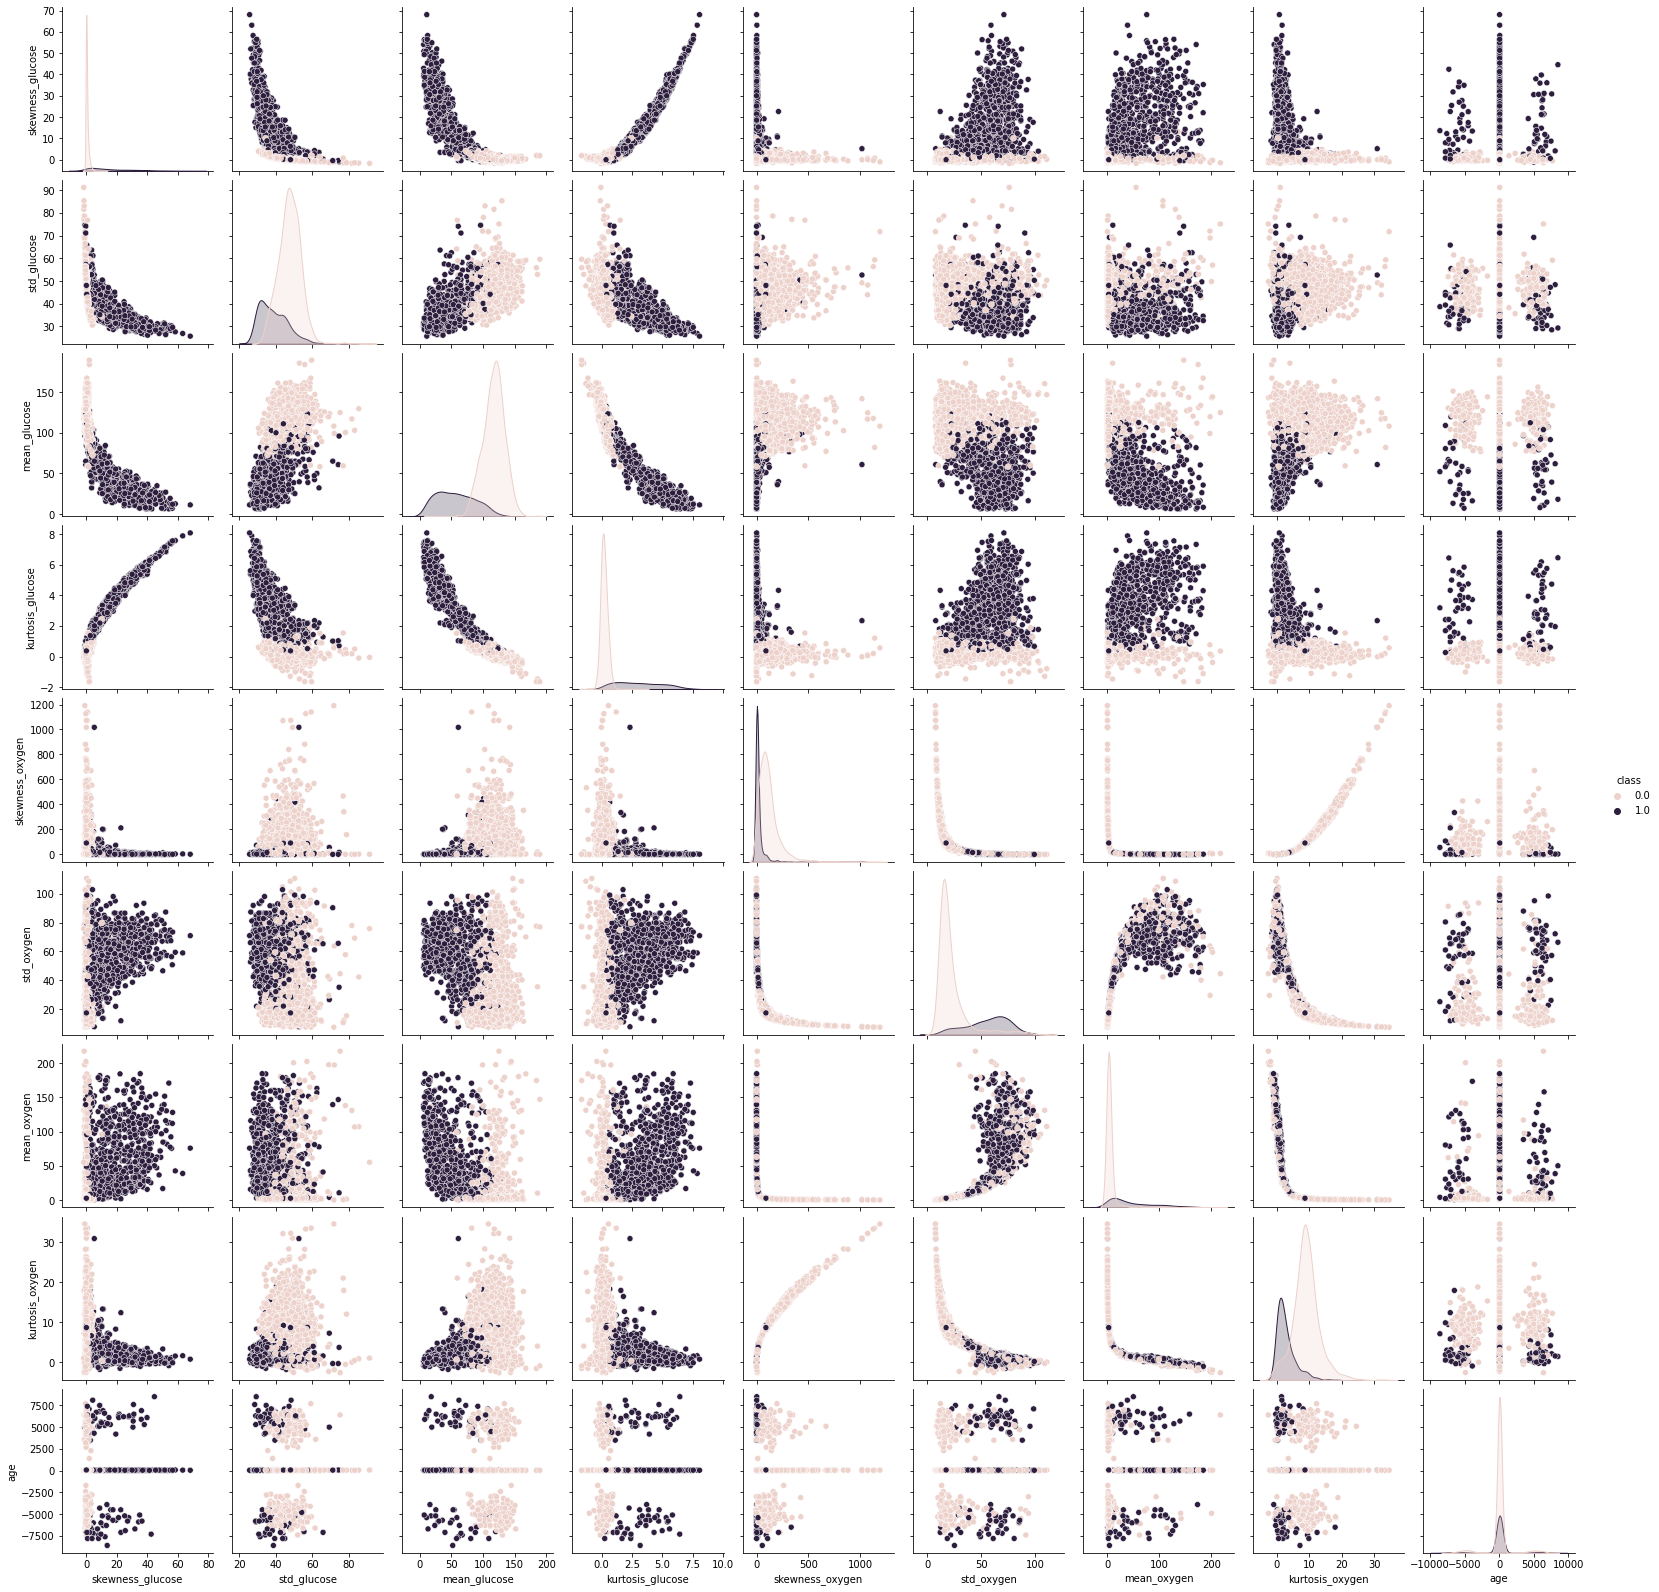

In [657]:
sns.pairplot(data, hue="class", vars=['skewness_glucose', 
                                      'std_glucose', 
                                      'mean_glucose',
                                      'kurtosis_glucose',
                                      'skewness_oxygen',
                                      'std_oxygen', 
                                      'mean_oxygen',
                                      'kurtosis_oxygen',
                                      'age'])

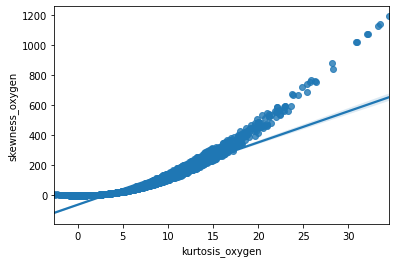

In [658]:
sns.regplot(x = "kurtosis_oxygen", y = "skewness_oxygen", data = data)

In [659]:
sns.regplot(x = "kurtosis_glucose", y = "skewness_glucose", data = data)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 3969 and the array at index 1 has size 3971

Zo všetkých kombinácií grafov vidíme, že veľmi silnú pozitívnu koreláciu preukazuje dvojica atribútov kurtosis_oxygen - skewness_oxygen a taktiež dvojica kurtosis_glucose - skewness_glucose. 

Istú, ale menšiu formu pozitívnej korelácie vykazujú aj dvojice premenných kurtosis_oxygen - mean_oxygen, kurtosis_glucose - mean_glucose a std_glucose - skewness_glucose.

Zaujímavé by bolo vidieť reálnu koreláciu medzi vekom a ostatnými nameranými hodnotami, z grafov je však zjavné, že stĺpec vek obsahuje mnoho nekorektných, záporných hodnôt. Na tento problem sa pozrieme pri úprave dát a potom bude potrebné sa pozrieť na vzťahy medzi vekom a inými premennými znova, keďže môže mať výpovednú hodnotu o ktorej zatiaľ kvôli chybovosti dát nevieme.

In [660]:
data.corr()

,kurtosis_oxygen,education-num,skewness_glucose,mean_glucose,std_oxygen,skewness_oxygen,kurtosis_glucose,class,std_glucose,mean_oxygen,age
kurtosis_oxygen,1.000000,-0.000973,-0.476767,0.467279,-0.842848,0.917105,-0.528195,-0.557520,0.245316,-0.660448,-0.000195
education-num,-0.000973,1.000000,0.011653,-0.018183,-0.012122,-0.006116,0.010221,-0.006258,-0.003609,0.001780,0.004915
skewness_glucose,-0.476767,0.011653,1.000000,-0.825978,0.555245,-0.311392,0.962058,0.680696,-0.665877,0.548593,0.011664
mean_glucose,0.467279,-0.018183,-0.825978,1.000000,-0.557693,0.302114,-0.925595,-0.776585,0.647815,-0.535626,-0.018412
std_oxygen,-0.842848,-0.012122,0.555245,-0.557693,1.000000,-0.605417,0.617406,0.648719,-0.272481,0.801455,0.014882
skewness_oxygen,0.917105,-0.006116,-0.311392,0.302114,-0.605417,1.000000,-0.346412,-0.391644,0.187852,-0.396208,0.008176
kurtosis_glucose,-0.528195,0.010221,0.962058,-0.925595,0.617406,-0.346412,1.000000,0.787638,-0.652432,0.593736,0.011360
class,-0.557520,-0.006258,0.680696,-0.776585,0.648719,-0.391644,0.787638,1.000000,-0.500658,0.516158,0.010477
std_glucose,0.245316,-0.003609,-0.665877,0.647815,-0.272481,0.187852,-0.652432,-0.500658,1.000000,-0.199614,-0.008994
mean_oxygen,-0.660448,0.001780,0.548593,-0.535626,0.801455,-0.396208,0.593736,0.516158,-0.199614,1.000000,-0.001341


Aby sme si potvrdili naše úvahy o korelácii dvoch atribútov, vypočítali sme si aj hodnotu korelácie. Hodnota korelácie blížiaca sa k 1, respektíve -1, značí vysokú mieru závislosti, vo všeobecnosti hodnota väčšia ako 0.9, alebo menšia ako -0.9 znači veľmi vysokú mieru korelácie, nižšie hodnoty však tiež nemusia byť na zahodenie. Pozitívna koreláci hovorí o tom, že ak jedna hodnota rastie, rastie spolu s ňou aj druhá a naopak negatívna hovorí o opačnom vzťahu, ak jedna premenná rastie, druhá klesá.

Ako silno pozitívne korelujúce teda môžeme označiť dvojice skewness_oxygen - kurtosis_oxygen a kurtosis_glucose - skewness_glucose a negatívne kurtosis_glucose - mean_glucose. Ak by sme určili hraničnú hodnotu záujmu napríklad na 0.80, dávalo by zmysel brať do úvahy aj dvojice mean_glucose - skewness_glucose, std_oxygen - kurtosis_oxygen.

## Spojité - kategorické atribúty

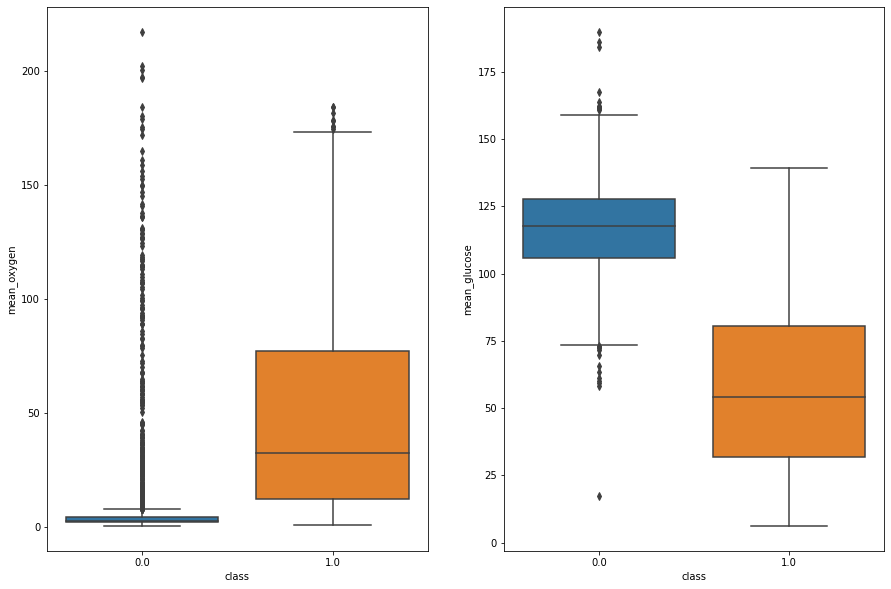

In [661]:
f, axes = plt.subplots(1, 2)

sns.boxplot(x='class', y='mean_oxygen', ax=axes[0], data=data)
sns.boxplot(x='class', y='mean_glucose', ax=axes[1], data=data)

f.set_figwidth(15)
f.set_figheight(10)

Z grafov reprezentujúcich vzťah medzi priemernými nameranými hodnotami kyslíka a glukózy v krvi a diagnózou cukrovky u vybraných pacientov môžeme vyvodiť nasledujúce zistenia. Keďže u jedincov, ktorí cukrovku nemajú je interkvantilové rozmedzie hodnôt príliš malé, môže to značiť, že táto nameraná hodnota nie je spolahlivým ukazovateľom či človek má alebo nemá cukrovku, keďže nie je vidno žiadnu príznačnú hodnotu. Naopak u pacientov, ktorí cukrovku majú, je interkvantilové rozmedzie veľké a outlierov je málo, no ani toto nemá veľkú výpovednú hodnotu samo o sebe, keďže interkvantilové rozmedzie zaberá pomerne veľkú časť nameraných hodnôt. Pri hladine glukózy, vyzerá, že táto hodnota je dôležitým ukazovateľom pri pacientoch ktorí cukrovku majú, aj nemajú. Keďže sa ale interkvantilové rozmedzia prelínajú, sama o sebe nie je dostatočným ukazovateľom, ale zároveň sa neprelínajú úplne, takže v istých hraničných hodnotách je tento ukazovateľ veľmi silný.

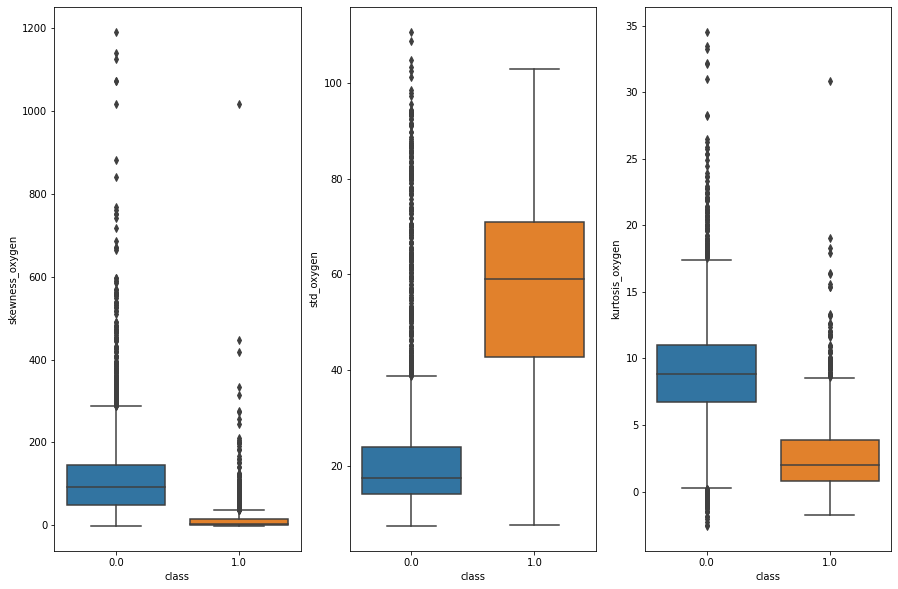

In [662]:
f, axes = plt.subplots(1, 3)

sns.boxplot(x='class', y='skewness_oxygen', ax=axes[0], data=data)
sns.boxplot(x='class', y='std_oxygen', ax=axes[1], data=data)
sns.boxplot(x='class', y='kurtosis_oxygen', ax=axes[2], data=data)

f.set_figwidth(15)
f.set_figheight(10)

Z grafov reprezentujúcich súvis hladiny kyslíka v krvi a výskytu cukrovky, vyzerá že najzaujímavejší ukazovateľ je skewness_oxygen, ten ak vystúpa nad nejakú hodnotu (okolo 300), vyzerá, že je iba veľmi malá šanca, že by pre dané meranie bola cukrovka pravdepodobná.

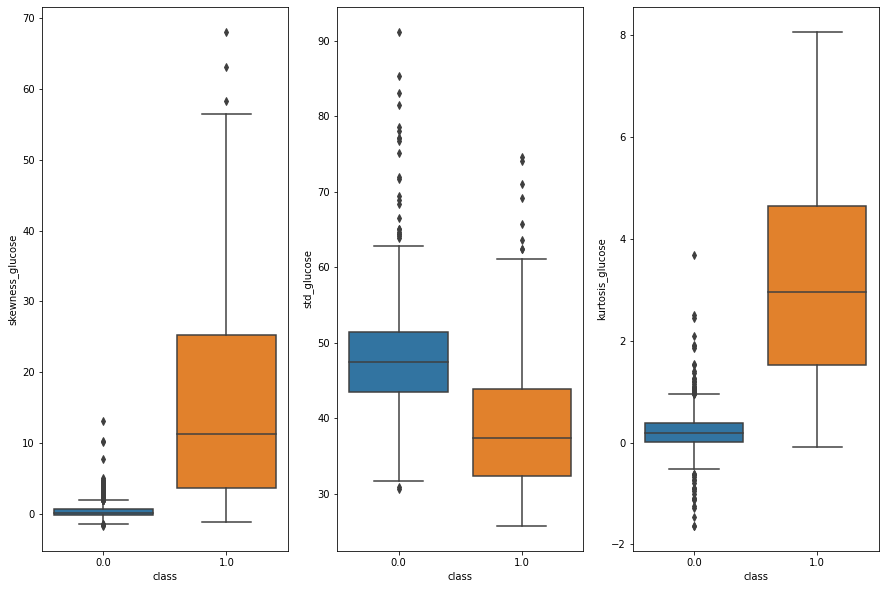

In [663]:
f, axes = plt.subplots(1, 3)

sns.boxplot(x='class', y='skewness_glucose', ax=axes[0], data=data)
sns.boxplot(x='class', y='std_glucose', ax=axes[1], data=data)
sns.boxplot(x='class', y='kurtosis_glucose', ax=axes[2], data=data)

f.set_figwidth(15)
f.set_figheight(10)

Pri hladine cukru v krvi môžeme zas pozorovať, že ak hodnota skewness a kurtosis vystúpa nad nejakú hodnotu (v prípade skewness zhruba 10, pri kurtosis 2), naopak šanca, že daný človek má cukrovku, je vyššia.

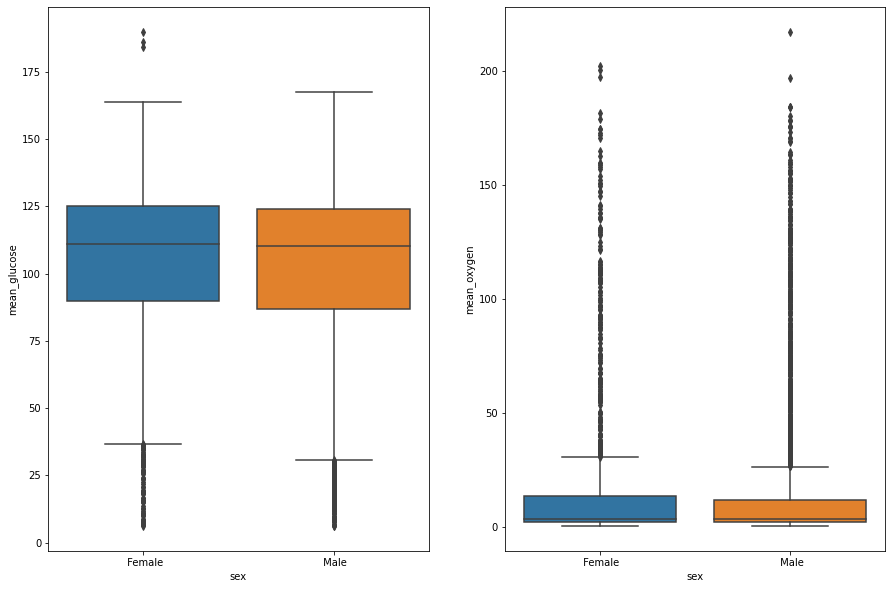

In [664]:
f, axes = plt.subplots(1, 2)

sns.boxplot(x='sex', y='mean_glucose', ax=axes[0], data=data)
sns.boxplot(x='sex', y='mean_oxygen', ax=axes[1], data=data)

f.set_figwidth(15)
f.set_figheight(10)

Z týchto dvojíc grafov môžeme vidieť, že kategorický atribút pohlavie nevplýva na hladinu cukru a kyslíku v krvi.

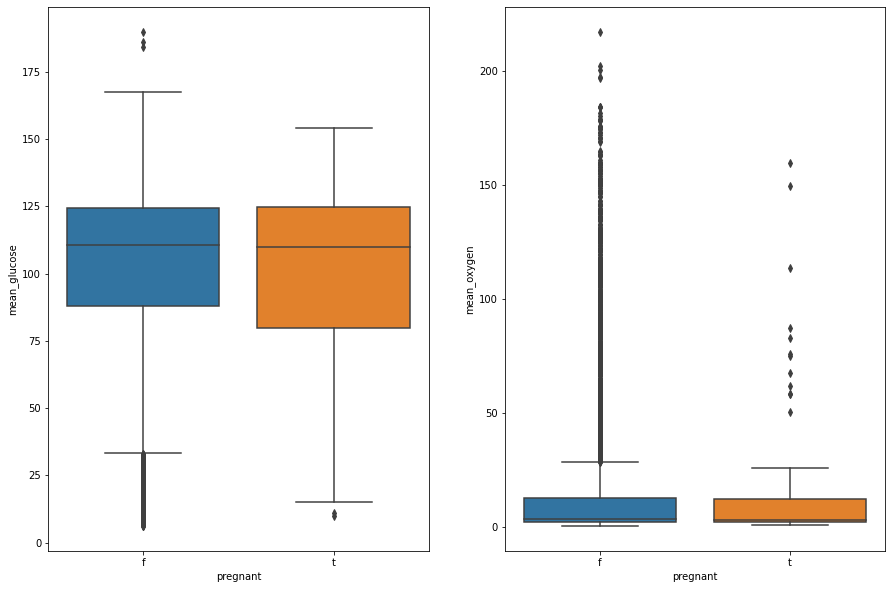

In [665]:
f, axes = plt.subplots(1, 2)

sns.boxplot(x='pregnant', y='mean_glucose', ax=axes[0], data=data)
sns.boxplot(x='pregnant', y='mean_oxygen', ax=axes[1], data=data)

f.set_figwidth(15)
f.set_figheight(10)

Z týchto dvojíc grafov môžeme vidieť, že ani kategorický atribút tehotenstva nevplýva na hladinu cukru a kyslíku v krvi. Chceli sme tieto hodnoty skontrolovať, aby sme vedeli, či náhodou na merania nevplýva aj nejaký iný atribút okrem diagnostiky cukrovky.

## Kategorické - kategorické atribúty

In [666]:
sexStats = pd.crosstab(index=data["sex"], 
                             columns=data["class"],
                             normalize='index')

sexStats.index= ["Female","Male"]

sexStats

class,0.0,1.0
Female,0.744615,0.255385
Male,0.745693,0.254307


Keďže aj pri osobách mužského, aj pri osobách ženského pohlavia predstavuje podieľ ľudí s cukrovkou zhruba jednu tretinu, vyzerá, že pohlavie nie je zaujímavým ukazovateľom, či je človek viac alebo menj náchylný na cukrovku.

In [667]:
female = data[(data['sex'] == ' Female')]

pregStats = pd.crosstab(index=female["pregnant"], 
                              columns=data["class"],
                              normalize='index')

pregStats.index= ["Not pregnant","Pregnant"]

pregStats

class,0.0,1.0
Not pregnant,0.745291,0.254709
Pregnant,0.726027,0.273973


Opäť vyzerá, že to, či žena je alebo nie je tehotná, nemá žiaden významný vplyv na to, či má alebo nemá cukrovku. Znova ide zhruba o tretinu žien v oboch kategóriach, ktoré cukrovkou trpia, no zároveň treba povedať, že o tehotných ženách máme výrazne menej dát a teda nevieme s istotou povedať na základe dostupných dát, či je táto hypotéza sptávna.

In [668]:
raceStats = pd.crosstab(index=data["race"], 
                              columns=data["class"], 
                              normalize='index')

raceStats

class,0.0,1.0
race,,
Amer-Indian-Eskimo,0.621622,0.378378
Asian-Pac-Islander,0.765957,0.234043
Black,0.763006,0.236994
Other,0.750000,0.250000
White,0.743235,0.256765


Znovu platí, že vyzerá, že ani rasa nemá vplyv na výskyt cukrovky.

In [669]:
eduStats = pd.crosstab(index=data["class"], 
                              columns=data["education-num"], 
                              normalize='columns')

eduStats

education-num,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
class,,,,,,,,,,,,,,,,
0.0,0.428571,0.636364,0.857143,0.717647,0.810345,0.703125,0.723404,0.735849,0.7552,0.734322,0.754839,0.775,0.72792,0.806931,0.746269,0.698113
1.0,0.571429,0.363636,0.142857,0.282353,0.189655,0.296875,0.276596,0.264151,0.2448,0.265678,0.245161,0.225,0.27208,0.193069,0.253731,0.301887


Jediný významný nárast v podiele ľudí s cukrovkov, bol pri školeskej dochádzke o dĺžke jeden rok, práve v tejto kategórii však máme veľmi málo záznamov, takže výsledok nie je úplne relevantný. Dokopy znova vyzerá, že ani výška dosiahnutého vzdelania na výskyt cukrovky vplyv nemá.

# Štatistické overenie hypotéz o dátach


## Prvá hypotéza

Nulová hypotéza H0: Ľudia, ktorým bola nameraná nižšia hladina cukru v krvi, majú väčšiu šancu, že im bola diagnostikovaná cukrovka - *rozdieľ medzi hladinou cukru v krvi u ľudí s cukrovkou a ľudí bez je signifikantný*.

Na základe párovej analýzy a vizuálneho porovnania vytvorených boxplotov môžeme vidieť, že namerané hodnoty sa pre dané skupiny líšia. Máme dve skupiny hodnôt, jednu kategorickú, prítomnosť cukrovky u človkea a jednu spojitú teda priemernú hladinu cukru v krvi. Vzťah týchto hodnôt je nezávislý, teda človek s istou hodnotou cukru v krvi buď cukrovku má, alebo nemá.

Vyberáme si teda medzi Mann-Whitneyho U-testom a T-testom, pričom predpoklady potrebné na to, aby sme mohli použiť T-test sú že dáta musia byť s normálnej distribúcie a mali by pochádzať zo vzoriek s podobnou varianciou.

In [670]:
diabetes = data.loc[data['class'] == 1, 'mean_glucose']

diabetes.describe()

count    908.000000
mean      56.796634
std       30.002992
min        6.187500
25%       31.798828
50%       54.132812
75%       80.445312
max      139.257812
Name: mean_glucose, dtype: float64

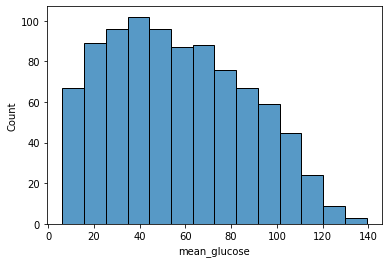

In [671]:
sns.histplot(diabetes)

Z tohto grafu môžeme videť že dáta sú naklonené smerom na ľavú stranu.

In [672]:
healthy = data.loc[data['class'] == 0, 'mean_glucose']

healthy.describe()

count    2650.000000
mean      116.534024
std        17.069795
min        17.210938
25%       105.904297
50%       117.558594
75%       127.771484
max       189.734375
Name: mean_glucose, dtype: float64

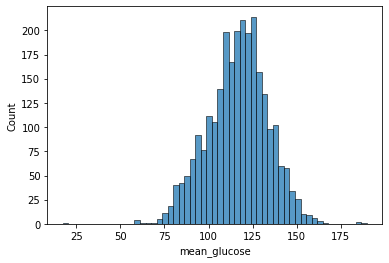

In [673]:
sns.histplot(healthy)

Z histogramu môžeme vidieť, že tento graf má pomerne veľa outlierov, ktorí nám budú neskôr skreslovať QQ-plot, tak ich vyhodíme.

In [674]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]

outliers = identify_outliers(healthy)

In [675]:
healthy = healthy.drop(outliers.index)

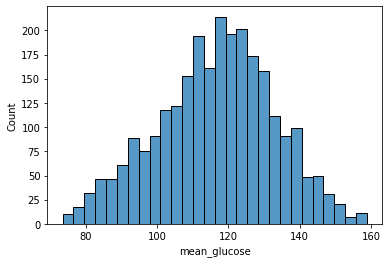

In [676]:
sns.histplot(healthy)

### Predpoklad normálneho rozdelenia

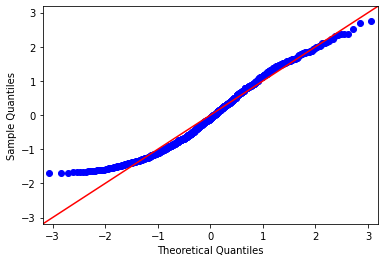

In [677]:
QQdiabetes = sm.ProbPlot(diabetes, fit=True).qqplot(line='45' )

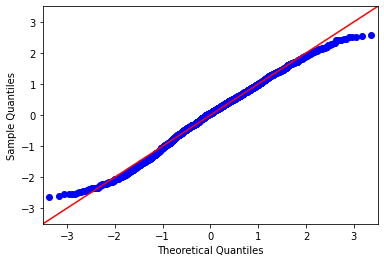

In [678]:
QQhealthy = sm.ProbPlot(healthy, fit=True).qqplot(line='45' )

Oba grafy vyzerajú podobne, mohli by byť z rovakého rozdelenia, vytočený chvost indikuje, že dáta sú trocha naklonené, vidieť je to hlavne v prípade grafu cukrovkárov, kde je tento posun výraznejší.

Aby sme si ale mohli byť istí, otestujeme tieto dve rozdelenia Shapiro-Wilkov testom normálnosti, ktorý zamietne alebo potvrdí nulovú hypotézu H0, že dáta pochádzajú z normálneho rozdelenia.

In [679]:
stats.shapiro(diabetes)

ShapiroResult(statistic=0.9707691073417664, pvalue=1.5659850803248498e-12)

In [680]:
stats.shapiro(healthy)

ShapiroResult(statistic=0.9939407110214233, pvalue=5.92472870764027e-09)

Keďže pri oboch rozdeleniach vyšla hodnota pvalue < 0.05, dáta pravdepodobne pochádzajú z iného ako normálneho rozdelenia. Varianciu už teda ani overovať nemusíme, vieme, že musíme použiť neparametrický Mann-Whitneyho U-test.

In [681]:
stats.mannwhitneyu(healthy,diabetes)

MannwhitneyuResult(statistic=108743.5, pvalue=0.0)

Keďže je hodnota pvalue < 0.001, šanca, že je nulová hypotéza pravdivá a my ju zamietneme je malá - *rozdieľ medzi hladinou cukru v krvi u ľudí s cukrovkou a ľudí bez je signifikantný.*

## Druhá hypotéza
Pri hladine cukru v krvi môžeme zas pozorovať, že ak hodnota skewness a kurtosis vystúpa nad nejakú hodnotu
Nulová hypotéza H0: Ľudia, ktorých nameraná hodnota cukru v krvi vykazuje vysoké hodnoty koeficientu špicatosti, majú vyššiu šancu, že majú cukrovku - *rozdieľ medzi koeficientom špicatosti hladiny cukru v krvi u ľudí s cukrovkou a ľudí bez je signifikantný*.

Na základe párovej analýzy a vizuálneho porovnania vytvorených boxplotov môžeme vidieť, že namerané hodnoty sa pre dané skupiny líšia. Opäť áme dve skupiny hodnôt, jednu kategorickú, prítomnosť cukrovky u človkea a jednu spojitú teda koeficient špicatosti nameraný popri priemernej hladine cukru v krvi. Vzťah týchto hodnôt je nezávislý. Vyzerá to tak, že najmä vyššie hodnoty tohto koeficientu vykazujú prítomnosť cukrovky.

Znovu si vyberáme teda medzi Mann-Whitneyho U-testom a T-testom, pričom predpoklady potrebné na to, aby sme mohli použiť T-test sú že dáta musia byť s normálnej distribúcie a mali by pochádzať zo vzoriek s podobnou varianciou.

In [682]:
diabetes = data.loc[data['class'] == 1, 'kurtosis_glucose']

diabetes.describe()

count    1010.000000
mean        3.110753
std         1.882821
min        -0.094888
25%         1.515940
50%         2.960728
75%         4.641521
max         8.069522
Name: kurtosis_glucose, dtype: float64

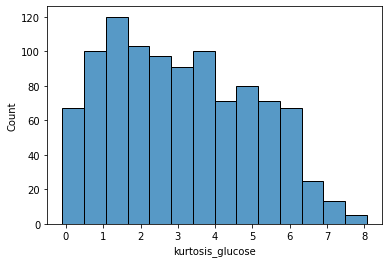

In [683]:
sns.histplot(diabetes)

Opäť vyzerá, že aj tieto dáta sú naklonené smerom doľava, hodnoty sú pekne súvislé, nevidno žiadnych outlierov.

In [684]:
healthy = data.loc[data['class'] == 0, 'kurtosis_glucose']

healthy.describe()

count    2949.000000
mean        0.207335
std         0.321111
min        -1.641515
25%         0.009230
50%         0.184205
75%         0.389788
max         3.691603
Name: kurtosis_glucose, dtype: float64

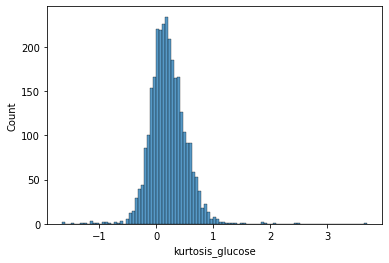

In [685]:
sns.histplot(healthy)

Opäť je potrebné odstrániť outlierov, aby QQ plot nebol skreslený.

In [686]:
outliers = identify_outliers(healthy)

In [687]:
healthy = healthy.drop(outliers.index)

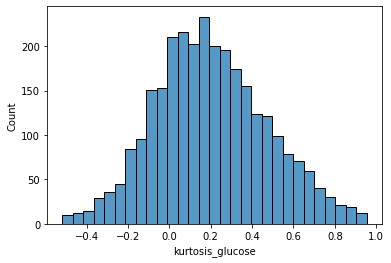

In [688]:
sns.histplot(healthy)

### Predpoklad normálneho rozdelenia

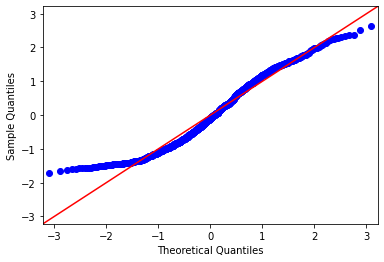

In [689]:
QQdiabetes = sm.ProbPlot(diabetes, fit=True).qqplot(line='45' )

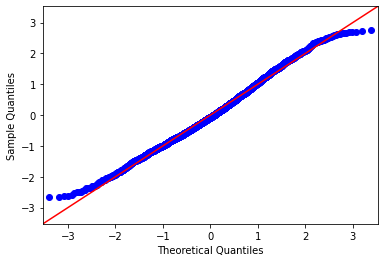

In [690]:
QQhealthy = sm.ProbPlot(healthy, fit=True).qqplot(line='45' )

In [691]:
stats.shapiro(diabetes)

ShapiroResult(statistic=0.9628087282180786, pvalue=2.269773224691904e-15)

In [692]:
stats.shapiro(healthy)

ShapiroResult(statistic=0.9943335056304932, pvalue=3.88843890419821e-09)

Keďže opäť pri oboch rozdeleniach vyšla hodnota pvalue < 0.05, dáta pravdepodobne pochádzajú z iného ako normálneho rozdelenia. Varianciu už teda ani overovať nemusíme, vieme, že musíme použiť neparametrický Mann-Whitneyho U-test.

In [693]:
stats.mannwhitneyu(healthy,diabetes)

MannwhitneyuResult(statistic=75643.0, pvalue=0.0)

Keďže je hodnota pvalue < 0.001, šanca, že je nulová hypotéza pravdivá a my ju zamietneme je malá - *rozdieľ medzi koeficientom špicatosti hladiny cukru v krvi u ľudí s cukrovkou a ľudí bez je signifikantný.*

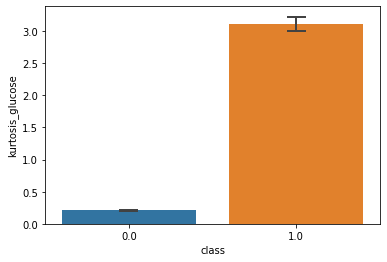

In [694]:
sns.barplot(x='class', y='kurtosis_glucose', data=data, 
            capsize=0.1, errwidth=2)

In [695]:
sms.DescrStatsW(healthy).tconfint_mean()

(0.19230084893943056, 0.2120570474525501)

In [696]:
sms.DescrStatsW(diabetes).tconfint_mean()

(2.9944960309950046, 3.2270092671178654)

Z posledného grafu je vidno, že priemerné hodnoty koeficientu špicatosti pri meraní glukózy sa veľmi odlišujú, čo nam potvrdil ajštatistický test - tieto hodnoty sú pravdepodobne signifikantné pri určovaní cukrovky. Pod grafom vypísané rozmedzia, znázornéne na grafe čiernymi úsekmi hovoria o tom, v akom rozmedzí sa pravdepodobne bude pohybovať priemerná hodnota.

# Identifikácia chýb v dátach

Zložený atribút personal_info obsahuje niekoľko dalších atribútov v jednom stĺpci
 - Riešenie: rozbiť tieto atribúty do samostaných stĺpcov a vložiť ich do tabuľky (už vykonané pri základnej úprave dát)

Nejednotné formáty dát atribútu „date of birth“ v personal_train.csv
 - Riešenie: zjednotiť formáty aby boli jednoznačné, odstrániť čas


In [697]:
data.date_of_birth.unique()

array(['50-06-08', '1960-07-28 00 00 00', '1984-08-04', ..., '07/02/1954',
       '1971-03-09', '1943-02-03'], dtype=object)

Nemožné hodnoty atribútu age v personal_train.csv (napríklad vek - 5600), alebo nesediace hodnoty veku podla dátumu narodenia
 - Riešenie: vypočítať reálny vek podľa dátumu narodenia
 

In [698]:
data[data['age'] < 0].shape[0]

201

Nemožné nastavenie atribútu pregnant na true pri osobe mužského pohlavia
 - Riešenie: prejsť všetky záznamy a skontrolovať, či je pri osobách mužského pohlavia nastavený atribút pregnant na true. Ak áno, zmeniť na false *LGBTI trigger warning*
 

In [699]:
data[(data['sex'] == ' Male') & (data['pregnant'] == 't')].shape[0]

17

Hodnoty atribútov pregnant a sex sú stringy, prípadne iné
 - Riešenie: Upraviť hodnoty atribútov pregnant a sex na numerické hodnoty, aby sme mohli na ne použiť deskriptívnu štatistiku, zamyslieť sa, či netreba prekonvertovať pomocou numerických hodnôt napríklad stĺpec income na kategorický atribút
 
Duplikátne záznamy jednej osoby
 - Riešenie: úplne sa zhodujúce záznamy odstrániť, pri dopľňajúcich sa spojiť tieto záznamy dohromady, pričom jeden sa na konci vymaže, pretože jeden záznam môže obsahovať NaN pre určitý atribút, zatiaľ čo druhý záznam môže tento záznam obsahovať a tým pádom ho môžeme použiť. Záznam ktorý nebude zmazaný ale všetky ostatné budú doňho spojené je ten, ktorý obsahuje najviac informácií o entite. Čo ak sa ale stane, že dva zaznamy jednej osoby sa v nejakom atribúte líšia? Ktorý vyberiem? 


In [700]:
data[data.duplicated()]

ValueError: operands could not be broadcast together with shapes (3983,) (3971,) (3983,) 

In [701]:
data[data.duplicated(subset='name')]

,name,kurtosis_oxygen,pregnant,education-num,skewness_glucose,mean_glucose,std_oxygen,skewness_oxygen,kurtosis_glucose,class,std_glucose,mean_oxygen,age,sex,date_of_birth,country,race
752,Jerry Garza,NaN,f,9.0,1.400578,81.156250,15.501749,124.384555,0.554911,0.0,40.249891,2.277592,53,Male,02/02/1966,United-States,White
860,Howard Barr,22.981701,NaN,14.0,0.202784,107.187500,8.917347,596.835211,0.166867,NaN,46.811749,0.512542,55,Male,1964/08/31,NaN,NaN
911,Donald Loftis,NaN,NaN,9.0,-0.042424,141.242188,28.768944,39.578610,-0.423370,0.0,49.169469,5.470736,4200,Male,1977-07-28,United-States,White
950,Willie Elford,7.318190,f,9.0,NaN,133.273438,NaN,66.417793,0.152192,0.0,52.696910,3.464047,50,Female,1969-05-01,United-States,White
1265,Todd Gilles,11.044669,NaN,13.0,-0.182290,NaN,13.424976,161.633761,0.219174,0.0,46.709727,2.091137,40,Female,1979-08-24,United-States,White
1337,Kenneth Wilson,9.973464,f,9.0,NaN,128.937500,16.939858,112.590823,NaN,0.0,52.308990,2.092809,44,Male,1975-04-14,United-States,White
1436,John Kieffer,NaN,t,13.0,NaN,124.664062,NaN,170.924411,0.050878,0.0,52.670152,NaN,59,Female,1960-07-17,United-States,White
1455,Calvin Drake,0.288687,NaN,NaN,-0.202795,149.421875,93.803112,-1.760862,-0.299657,NaN,49.993220,NaN,62,Male,1957-07-22,United-States,White
1596,Ryan Na,10.606203,t,12.0,0.395583,107.937500,14.001759,139.596876,0.385219,0.0,45.316034,1.849498,56,Female,1963-04-08,United-States,White
1730,James Mills,4.693831,f,6.0,-0.050316,NaN,NaN,NaN,NaN,0.0,NaN,7.280100,50,Male,68-12-02,United-States,White


Chýbajúce hodnoty v dátach
 - Riešenie: niektoré NaN hodnoty sa po spojení duplikátnych záznamov doplnia. S ostatnými chýbajúcim dátami sa môžeme vysporiadať niekoľkými spôsobmi. Pokiaľ sú chýbajúce hodnoty okolo najčastejšej hodnoty, môžeme ich nahradiť priemernou hodnotou daného atribútu alebo aj mediánom alebo modusom, podľa toho kde sa najviac tieto chýbajúce hodnoty vyskytujú. Môžeme tiež nájsť podobné pozorovania pomocou známych atribútov a doplniť chýbajúce hodnoty agregovaním hodnôt podobných pozorovaní. Ako posledná možnosť po vyčerpaní všetkých iných by malo byť mazanie týchto záznamov


In [702]:
data.isna().sum()

name                  0
kurtosis_oxygen      21
pregnant             15
education-num        11
skewness_glucose     12
mean_glucose        416
std_oxygen           18
skewness_oxygen      15
kurtosis_glucose     14
class                13
std_glucose           9
mean_oxygen          14
age                   0
sex                   0
date_of_birth         0
country              13
race                 13
dtype: int64

Outliers
 - Riešenie: odstránenie outlierov alebo nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom), alebo transformácia atribútu outlierov funkciou (logaritmus, odmocnina, ...)


# PREDSPRACOVANIE

## Spájanie dát a odstránenie duplicitných záznamov

In [703]:
data

,name,kurtosis_oxygen,pregnant,education-num,skewness_glucose,mean_glucose,std_oxygen,skewness_oxygen,kurtosis_glucose,class,std_glucose,mean_oxygen,age,sex,date_of_birth,country,race
0,Brian Newhall,8.289889,f,14.0,-0.378956,119.445312,17.929757,81.346517,0.012830,0.0,53.143057,2.932274,69,Female,50-06-08,United-States,White
1,Patrick Behne,4.322444,t,6.0,4.146348,77.085938,43.980061,17.860235,1.620462,1.0,43.391932,10.596154,59,Male,1960-07-28 00 00 00,United-States,Black
2,Steven Arnold,4.702130,f,5.0,-0.170853,126.046875,36.950157,21.100617,-0.139295,0.0,50.909365,7.939799,3500,Male,1984-08-04,United-States,White
3,Mark Turner,15.348017,f,13.0,0.219464,109.289062,13.871366,243.333462,0.352015,1.0,50.772802,0.950669,56,Male,1963-01-24,United-States,White
4,Mike Sams,1.972958,f,12.0,18.011655,53.789062,67.752058,2.336556,3.231805,1.0,30.062085,30.670569,41,Male,1978-01-18,United-States,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,Robert Mcginity,0.632559,f,10.0,0.500946,NaN,85.327338,-1.547940,0.616738,0.0,48.549653,63.167224,47,Female,31/10/1971,United-States,White
3979,Walter Hicks,12.589633,t,10.0,-0.047254,115.742188,12.480348,193.799981,0.251630,0.0,48.494563,1.367057,48,Female,1971-10-03,United-States,Amer-Indian-Eskimo
3980,Peter Arnold,6.906414,f,12.0,-0.699136,128.843750,19.108528,57.836164,0.049967,0.0,56.151502,3.765886,65,Female,07/02/1954,United-States,White
3981,Roosevelt Jackson,8.073714,f,11.0,-0.487884,129.140625,15.341593,87.413616,0.169050,0.0,54.714705,2.766722,48,Male,1971-03-09,United-States,White


Pri prieskumnej analýze sme vykonali iba nevyhnutné zmeny v dátach, aby sme ich vedeli zobrazovať, a spojili sme dve vstupné tabuľky do jednej. Zostalo nám po tejto úprave 17 stĺpcov, pričom v nasledujúcom kroku odstránime stĺpce, ktoré sme pri prieskumnej analýze identifikovali ako nemajúce vplyv na to, či pacient cukrovku má alebo nemá. Pre zatiaľ ponecháme meno a dátum narodenia, keďže ich budeme potrebovať na identifikáciu jednotlivých záznamov a dopočítanie hodnôt.

In [704]:
def dropColumnsSecond(data):
    data = data.drop('pregnant', axis = 1)
    data = data.drop('education-num', axis = 1)
    data = data.drop('sex', axis = 1)
    data = data.drop('country', axis = 1)
    data = data.drop('race', axis = 1)
    
    return data

data = dropColumnsSecond(data)

In [705]:
import datetime

def standardTimestamp():
    for index, row in data.iterrows():
        dateStr = row['date_of_birth']
        
        dateList = []
        
        if '-' in dateStr:
            dateList = dateStr.split('-', 2)
        
        if '/' in dateStr:
            dateList = dateStr.split('/', 2)
        
        # odstranenie casu
        if ' ' in dateList[2]:
            dateList[2] = dateList[2].split(' ')[0]
            
        # europsky zapis datumu
        if int(dateList[2]) > 31:
            pom = dateList[0]
            
            dateList[0] = dateList[2]
            dateList[2] = pom
        
        # neuplny zapis roku
        if len(dateList[0]) == 2:
            dateList[0] = '19' + dateList[0]
        
        date = datetime.datetime(int(dateList[0]), int(dateList[1]), int(dateList[2])).date()
        
        data.at[index, 'date_of_birth'] = date
        
standardTimestamp()

Vo funkcii standardTimestamp( ) sme nahradili roznorode formaty dat jednym univerzalnym datetime zapisom, tento nizsie pouzijeme na vypocet rokov pre chybajuce hodnoty, alebo nerealne hodnoty, teda hodnoty mensie ako 0 a vacsie ako 100.

In [706]:
def calcAge():
    for index, row in data.iterrows():
        age = row['age']
        date = row['date_of_birth']
        
        if age < 0 or age > 100:
            newAge = 2019 - date.year
            data.at[index, 'age'] = newAge

calcAge()

Vo funkcii calcAge( ) sme všetky nereálne hodnoty veku nahradili ich výpočtom na základe dátumu narodenia k roku 2019, keďže vyzerá, že merania pochoádzajú práve z tohoto roku.

In [707]:
def removeDuplicates(data):
    data = data.sort_values('name')\
                      .groupby('name').apply(lambda x: x.ffill().bfill())\
                      .drop_duplicates()

    data = data.reset_index(drop=True)
    
    return data

data = removeDuplicates(data)

Vo funkcii removeDuplicates( ) sme doplnili v prvom výskyte duplikátu hodnoty stĺpcov z druhého výskytu duplikátneho riadku a naopak. Keďže nám vzniklo týmto spájaním 50 dvojíc úplne rovnakých riadkov a pôvodne bolo 100 riadkov identifikovaných ako majúcich rovnaké meno, duplikátne riadky sme mohli odstrániť - nemuseli sme riešiť žiadne priemerovanie hodnôt. Duplikáty sme zmazali, aby nam zostal iba jeden riadok pre každé pozorovanie.

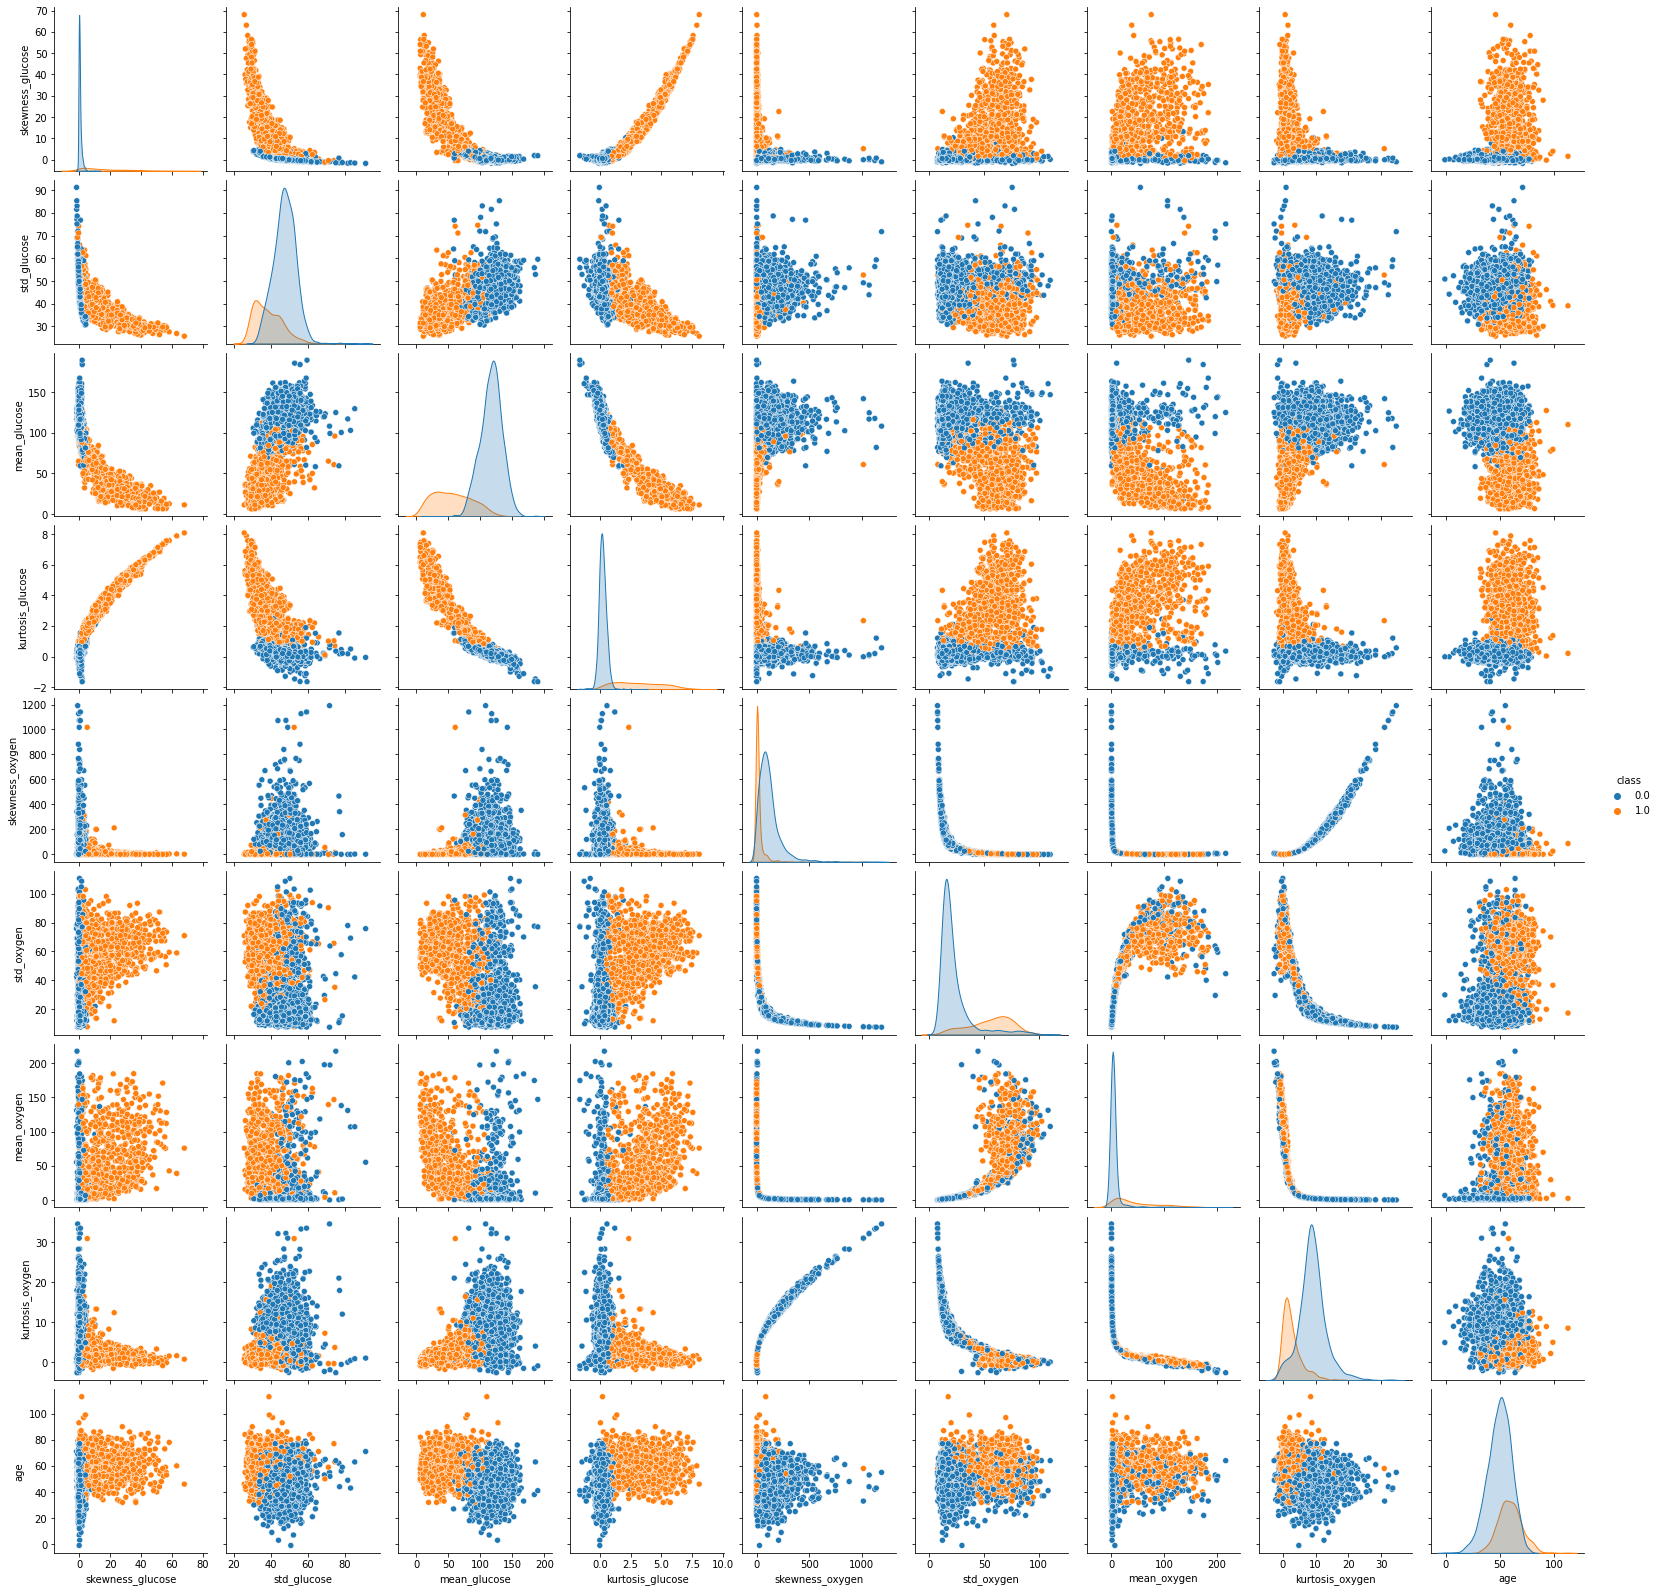

In [708]:
sns.pairplot(data, hue="class", vars=['skewness_glucose', 
                                      'std_glucose', 
                                      'mean_glucose',
                                      'kurtosis_glucose',
                                      'skewness_oxygen',
                                      'std_oxygen', 
                                      'mean_oxygen',
                                      'kurtosis_oxygen',
                                      'age'])

Po upravení dát sme vytvorili nový pairplot, aby sme sa pozreli hlavne na vzťah medzi vekom a ostatnými premennými - vyzerá, že ani vek nekoreluje s výskytom cukrovky, môže byť však zaujímavý vo vzťahu k ostatným nameraným hodnotám. Pre zatiaľ sme sa rozhodli si ho nechať a pozrieme sa na neho bližšie, aby sme na isto vedeli, že ho môžeme odstrániť.

In [742]:
bins = [0, 18, 40, 65, np.inf]
names = ['0-18', '18-40', '40-65', '65']

data['age_range'] = pd.cut(data['age'], bins, labels=names)

data

,kurtosis_oxygen,skewness_glucose,mean_glucose,std_oxygen,skewness_oxygen,kurtosis_glucose,class,std_glucose,mean_oxygen,age,age_range
0,8.097738,0.081270,100.171875,23.767031,68.181397,0.428540,0.0,51.755753,3.240803,48,40-65
1,9.985311,0.029417,118.757812,12.913238,145.021206,0.215271,0.0,46.036457,2.287625,54,40-65
2,4.687513,2.536933,84.085938,37.633310,21.720603,1.365958,1.0,44.531068,8.618729,73,65
3,9.218707,0.190308,114.070312,16.987123,94.161483,0.244839,0.0,49.162864,2.142977,49,40-65
4,14.571388,1.006536,NaN,12.467005,243.972157,0.629684,0.0,44.472378,1.156355,58,40-65
...,...,...,...,...,...,...,...,...,...,...,...
3928,1.352279,6.245728,66.007812,75.944796,0.433760,2.182436,1.0,43.051476,48.550167,45,40-65
3929,9.133436,-0.477533,109.664062,17.874913,93.991725,0.289527,0.0,56.167339,2.418060,62,40-65
3930,9.903094,0.512467,99.343750,15.343608,113.305050,0.395217,0.0,47.023837,1.828595,53,40-65
3931,1.908002,10.988138,62.656250,56.464582,2.859559,2.968953,1.0,38.243553,29.587793,63,40-65


In [743]:
ageStats = pd.crosstab(index=data["age_range"], 
                              columns=data["class"], 
                              normalize='index')

ageStats

class,0.0,1.0
age_range,,
0-18,1.000000,0.000000
18-40,0.942215,0.057785
40-65,0.752371,0.247629
65,0.407658,0.592342


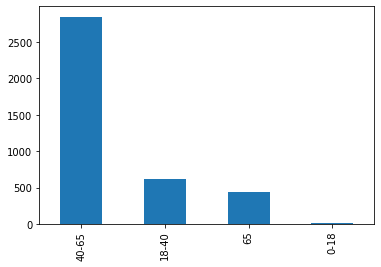

In [744]:
data['age_range'].value_counts().plot(kind='bar')

Skúsili sme rozdeliť dáta do vekových kategórií, avšak aj keď rozdiely v percentách vyzerajú sľubne, z histogramu môžeme vidieť, že väčšina dát je z jednej kategórie, preto nemôžeme považovať výsledky za veľavravné. Pre zatiaľ teda vek aj zoskupenie podľa vekoj kategórie z nášho datasetu vyhodíme.

In [747]:
data = data.drop('age_range', axis = 1)

## Transformácie dát - doplnenie chýbajúcich hodnôt, štandardizácia a normalizácia

In [748]:
data.isna().sum()

kurtosis_oxygen       0
skewness_glucose      0
mean_glucose        394
std_oxygen            0
skewness_oxygen       0
kurtosis_glucose      0
class                 0
std_glucose           0
mean_oxygen           0
age                   0
dtype: int64

Vidíme, že teraz už je hodnôt, ktoré potrebujeme nejakým spôsobom dopočítať oveľa menej.

In [710]:
def fillMean(data):
    data['kurtosis_oxygen'].fillna(data['kurtosis_oxygen'].mean(), inplace=True)
    data['skewness_glucose'].fillna(data['skewness_glucose'].mean(), inplace=True)
    data['kurtosis_glucose'].fillna(data['kurtosis_glucose'].mean(), inplace=True)
    
    return data

data = fillMean(data)

Stĺpce, v ktorých nakoniec chýbala iba jedna hodnota sme doplnili priemernou hodnotou stĺpca, keďže chýbajúcich hodbôt je v pomere k dátam veľmi málo a môžeme tak s menšou škodou použiť menej presný spôsob dopĺňania. Na doplnenie hodnôt mean_glucose, ktorých chýba o dosť viac a to 394 použijeme presnejšiu metódu dopĺňania chýbajúcich hodnôt - kNN Imputation.

In [711]:
def dropColumnsFinal(data):
    data = data.drop('name', axis = 1)
    data = data.drop('date_of_birth', axis = 1)
    
    return data

data = dropColumnsFinal(data)

data

,kurtosis_oxygen,skewness_glucose,mean_glucose,std_oxygen,skewness_oxygen,kurtosis_glucose,class,std_glucose,mean_oxygen,age
0,8.097738,0.081270,100.171875,23.767031,68.181397,0.428540,0.0,51.755753,3.240803,48
1,9.985311,0.029417,118.757812,12.913238,145.021206,0.215271,0.0,46.036457,2.287625,54
2,4.687513,2.536933,84.085938,37.633310,21.720603,1.365958,1.0,44.531068,8.618729,73
3,9.218707,0.190308,114.070312,16.987123,94.161483,0.244839,0.0,49.162864,2.142977,49
4,14.571388,1.006536,NaN,12.467005,243.972157,0.629684,0.0,44.472378,1.156355,58
...,...,...,...,...,...,...,...,...,...,...
3928,1.352279,6.245728,66.007812,75.944796,0.433760,2.182436,1.0,43.051476,48.550167,45
3929,9.133436,-0.477533,109.664062,17.874913,93.991725,0.289527,0.0,56.167339,2.418060,62
3930,9.903094,0.512467,99.343750,15.343608,113.305050,0.395217,0.0,47.023837,1.828595,53
3931,1.908002,10.988138,62.656250,56.464582,2.859559,2.968953,1.0,38.243553,29.587793,63


Po vypočítaní ozajstných hodnôt veku a pospájaní záznamov na základe mena, ktoré slúžilo ako kľúč, si môžeme dovoliť stĺpce meno a dátum narodenia vymazať - potrebujeme tak urobiť preto, aby sme mohli dataset pustiť cez škálovacie funkcie kNN Imputer( ), PowerTransformer( ) a MinMaxScaler( ).

In [731]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

pipeline = Pipeline(steps=[('imputer', KNNImputer()),
                           ('standardizer', PowerTransformer()),
                           ('normalizer', MinMaxScaler())])

pipeline.fit(data)

scaledData = pipeline.transform(data)

Do pipeliny na transformovanie sme vložili tri transformácie. Najskôr sme doplnili chýbajúce dáta pre mean_glucose výpočtom podľa k najbližších susedov, potom sme dáta štandardizovali tak, aby sme odstránili vychýlenie a posunuli distribúciu okolo 0. V poslednom kroku sme dáta normalizovali tak, aby sa nachádzali proporčne k ich reálnym hodnotám v rozmedzí 0 až 1.

In [732]:
scaledDataFrame = pd.DataFrame(scaledData, index=dataNew.index, columns=dataNew.columns)

scaledDataFrame

,kurtosis_oxygen,skewness_glucose,mean_glucose,std_oxygen,skewness_oxygen,kurtosis_glucose,class,std_glucose,mean_oxygen,age
0,0.452191,0.694996,0.300325,0.604194,0.396598,0.814297,0.0,0.398767,0.535465,0.372561
1,0.501030,0.687444,0.413811,0.331222,0.505436,0.788480,0.0,0.311395,0.454897,0.426423
2,0.354802,0.838035,0.215944,0.759450,0.276405,0.882768,1.0,0.288387,0.728370,0.603275
3,0.481538,0.709329,0.383590,0.464338,0.439837,0.792451,0.0,0.359165,0.439412,0.381464
4,0.609942,0.778153,0.382008,0.312832,0.597930,0.833856,0.0,0.287490,0.293077,0.462898
...,...,...,...,...,...,...,...,...,...,...
3928,0.238589,0.896457,0.136764,0.932171,0.113225,0.915708,1.0,0.265767,0.926346,0.346040
3929,0.479343,0.581205,0.356162,0.487133,0.439582,0.798191,0.0,0.466118,0.467973,0.499796
3930,0.498961,0.742717,0.295665,0.417021,0.466803,0.810656,0.0,0.326484,0.401565,0.417373
3931,0.260435,0.928397,0.123937,0.867470,0.155787,0.937288,1.0,0.192230,0.885673,0.509084


Transformované dáta sme vložili do nového data frame pre naškálované hodnoty. Ďalej už budeme robiť s týmto data framom, vytvoríme nové box ploty, aby sme vedeli z upravených hodnôt identifikovať outlierov.

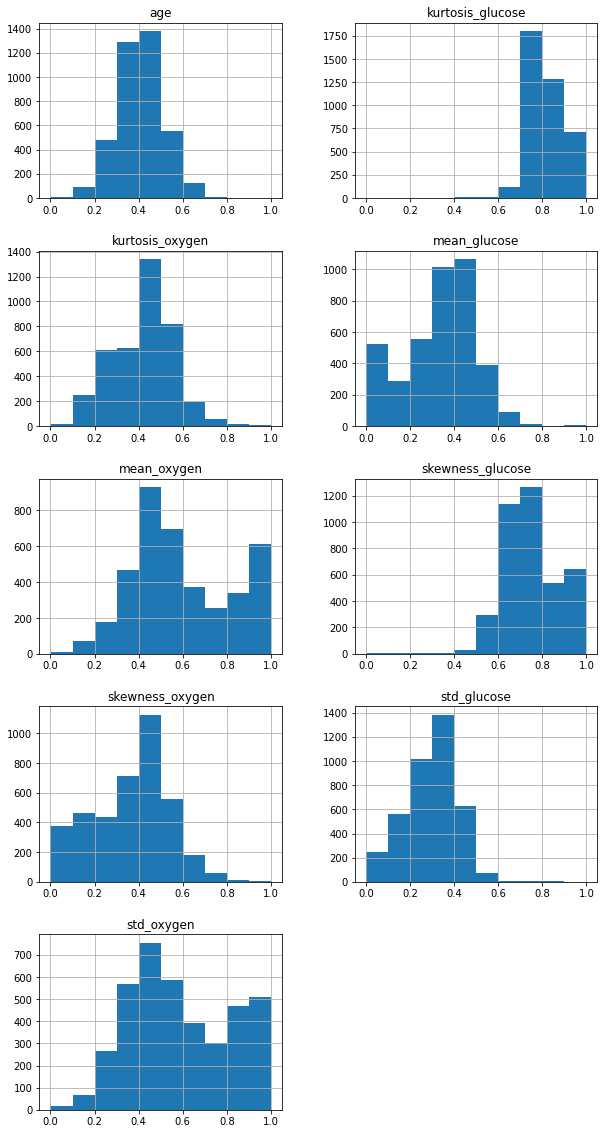

In [733]:
hists = scaledDataFrame.loc[:, scaledDataFrame.columns.difference(['class'])].hist(layout=(5,2), figsize=(10,20))

Z histogramov môžeme vidieť, že dáta sa naozaj viac podobajú na Gaussovu distribúciu a sú naškálované na rozmedzie hodnôt 1 až 0.

## Identifikácia a odstránenie vychýlených hodnôt

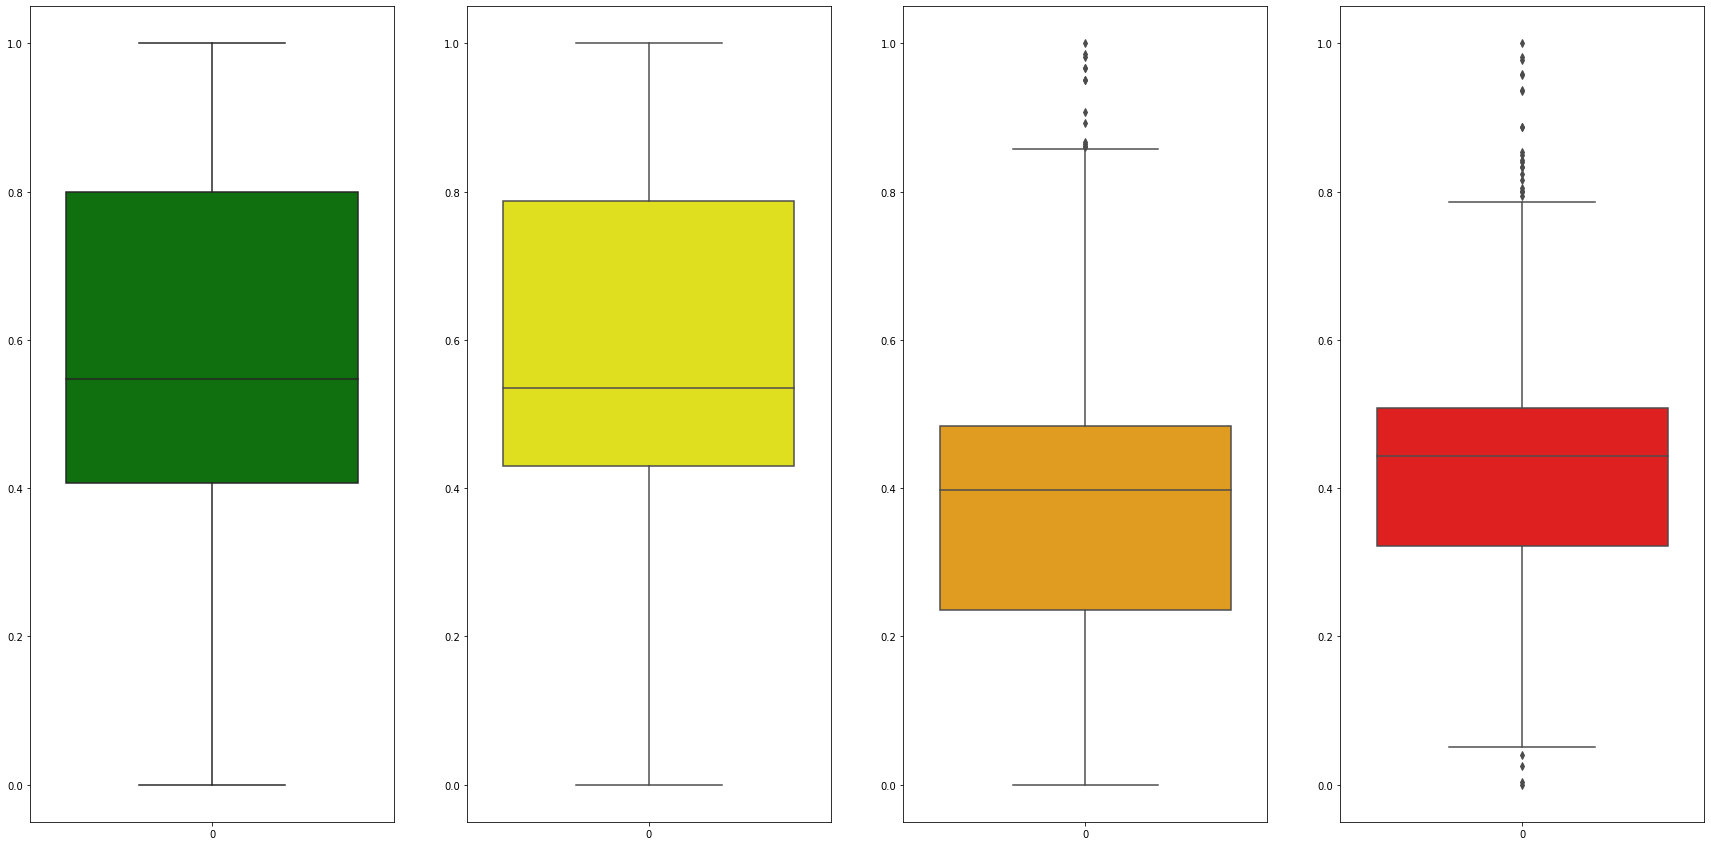

In [734]:
f, axes = plt.subplots(1, 4)
sns.boxplot(data = scaledDataFrame['std_oxygen'], orient='v', ax=axes[0], color = 'green')
sns.boxplot(data = scaledDataFrame['mean_oxygen'], orient='v', ax=axes[1], color = 'yellow')
sns.boxplot(data = scaledDataFrame['skewness_oxygen'], orient='v', ax=axes[2], color = 'orange')
sns.boxplot(data = scaledDataFrame['kurtosis_oxygen'], orient='v', ax=axes[3], color = 'red')

f.set_figwidth(30)
f.set_figheight(15)

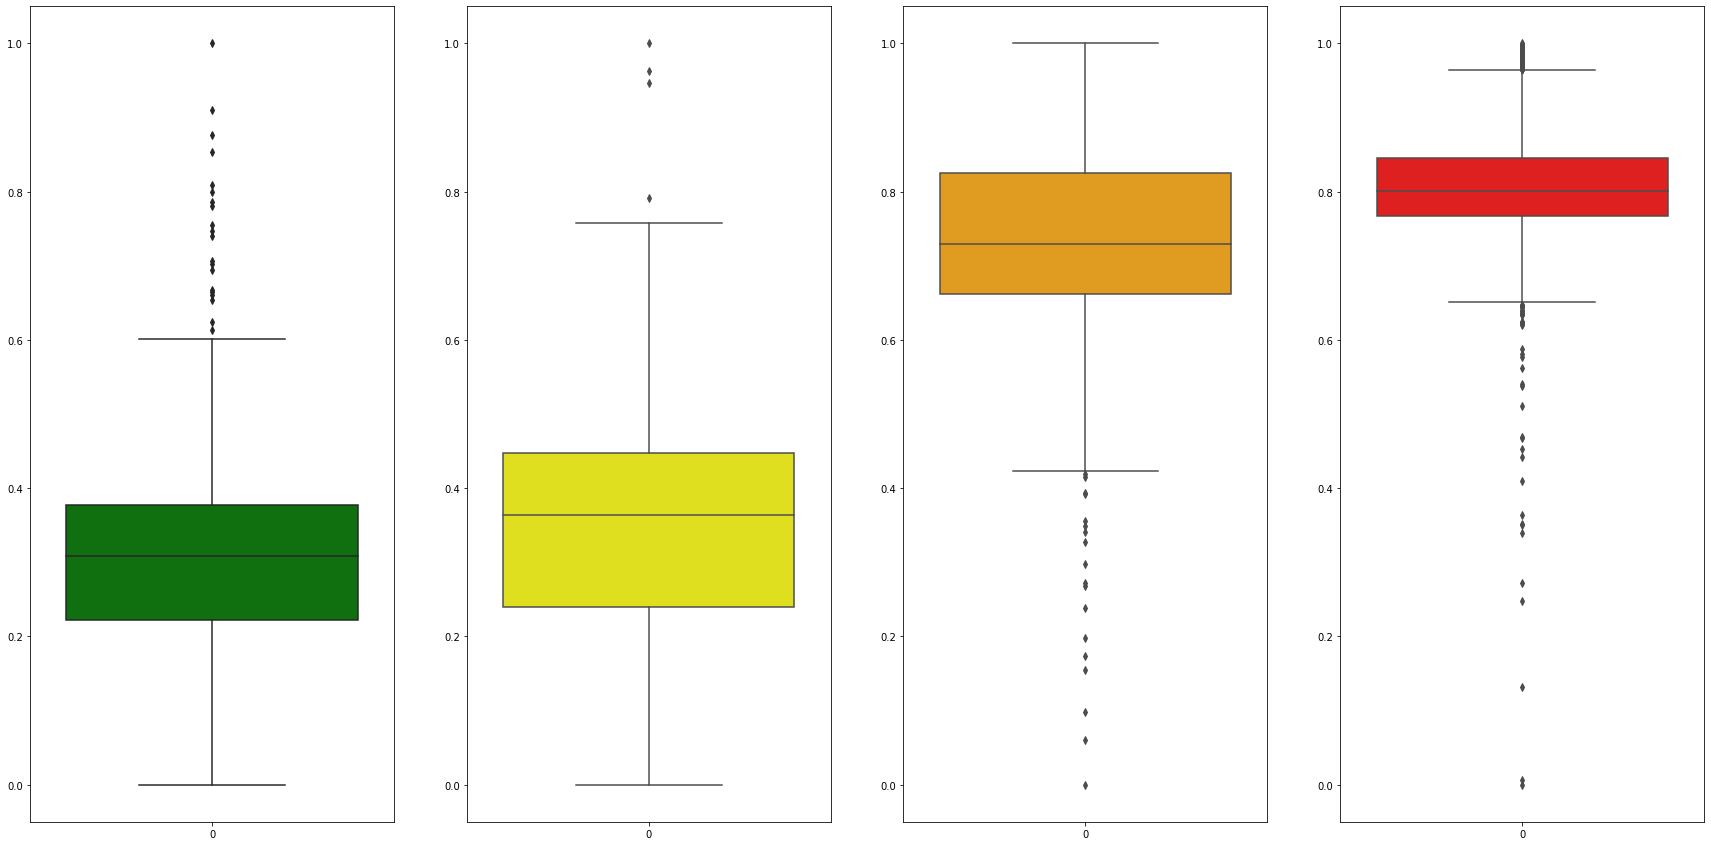

In [735]:
f, axes = plt.subplots(1, 4)
sns.boxplot(data = scaledDataFrame['std_glucose'], orient='v', ax=axes[0], color = 'green')
sns.boxplot(data = scaledDataFrame['mean_glucose'], orient='v', ax=axes[1], color = 'yellow')
sns.boxplot(data = scaledDataFrame['skewness_glucose'], orient='v', ax=axes[2], color = 'orange')
sns.boxplot(data = scaledDataFrame['kurtosis_glucose'], orient='v', ax=axes[3], color = 'red')

f.set_figwidth(30)
f.set_figheight(15)